# Look at DrugCentral's MOA targets and how they compare with our algorithm



In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from data_tools import df_processing as dfp

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')
paths_dir = load_dir.joinpath('16b_Model_results_analysis_DMDB', 'out')

dc_dir = load_dir.parent.joinpath('0_data', 'manual')

In [3]:
dc_ind = pd.read_csv(dc_dir.joinpath('dc_indications.csv'))
dc_tgt = pd.read_csv(dc_dir.joinpath('dc_targets.csv'))

In [4]:
this_name = '18_Target_Analysis-DrugCentral'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

In [119]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [6]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [7]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:54<00:00,  1.25it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:26<00:00,  2.53it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 119.51it/s]


In [8]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

In [9]:
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
id_to_name = nodes.set_index('id')['name'].to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()

In [12]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [13]:
msat = model[0]
max_abs = model[1]

In [14]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [15]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [16]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [17]:
def get_scal_dwpc_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    dwpc_metric = scal_metric * percent_of_total
    return dwpc_metric

In [18]:
def get_path_info(compound, disease, n_jobs=30, mps=None):
    if mps == None:
        mps = pos_coef
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, mps, n_jobs=n_jobs))
    if len(path_df) == 0:
        return None
    
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    path_df['scal_metric'] = get_scal_dwpc_metric(path_df)
    
    return path_df

## Get probabilites for Drugs in DrugCentral

In [19]:
feature_order = pd.read_csv(model_dir.joinpath('feature_order.txt'), header=None)[0].tolist()

In [20]:
dc_comp = dc_ind['chebi_id'].unique()
dc_dis = dc_ind['do_id'].unique()

(pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=feature_order, start_nodes=dc_comp,
                                        end_nodes=dc_dis, n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 156/156 [02:50<00:00,  1.09s/it]



Reshaping Result Matrices...


100%|██████████| 156/156 [00:00<00:00, 397.05it/s]


Stacking columns...


In [21]:
pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [22]:
pairs['chem_name'] = pairs['chemicalsubstance_id'].map(id_to_name)
pairs['dis_name'] = pairs['disease_id'].map(id_to_name)

In [23]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [24]:
dc_pos_tups = set(dc_ind[['chebi_id', 'do_id']].apply(tuple, axis=1))

In [25]:
status = []
dc_status = []
for row in pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))
    dc_status.append(int(bool(dc_pos_tups & {tup})))

In [26]:
pairs['status'] = status
pairs['dc_status'] = status
pairs.sample(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
85281,CHEBI:6073,DOID:12531,0.005413,Isradipine,von Willebrand's disease,0,0
55804,CHEBI:40279,DOID:3892,0.008515,allopurinol,insulinoma,0,0
90004,CHEBI:64354,DOID:2055,0.014470,metolazone,post-traumatic stress disorder,0,0
117459,CHEBI:8068,DOID:4362,0.005852,Phenmetrazine hydrochloride,cervical cancer,0,0
82155,CHEBI:59177,DOID:8534,0.008018,bromazine,gastroesophageal reflux disease,0,0
88372,CHEBI:63632,DOID:2456,0.012241,topotecan,blepharoconjunctivitis,0,0
30604,CHEBI:2950,DOID:4450,0.010824,azelastine,renal cell carcinoma,0,0
80838,CHEBI:5801,DOID:0060224,0.051682,hydroxychloroquine,atrial fibrillation,0,0
83891,CHEBI:59692,DOID:11396,0.005413,cycrimine,pulmonary edema,0,0
67235,CHEBI:49040,DOID:14275,0.005413,ezetimibe,atrophic vulva,0,0


In [27]:
pairs.query('dc_status == 1').sample(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
84883,CHEBI:6043,DOID:750,0.012480,Isopropamide,peptic ulcer disease,1,1
57583,CHEBI:42797,DOID:11257,0.007814,gabapentin,social phobia,1,1
99430,CHEBI:6887,DOID:8986,0.084632,methylphenidate,narcolepsy,1,1
90532,CHEBI:6446,DOID:1459,0.024517,levothyroxine sodium anhydrous,hypothyroidism,1,1
56898,CHEBI:41423,DOID:381,0.037704,celecoxib,arthropathy,1,1
80905,CHEBI:5801,DOID:12978,0.018401,hydroxychloroquine,Plasmodium vivax malaria,1,1
111933,CHEBI:77590,DOID:2378,0.006305,armodafinil,relapsing-remitting multiple sclerosis,1,1
57383,CHEBI:41879,DOID:1612,0.890391,dexamethasone,breast cancer,1,1
56393,CHEBI:4031,DOID:841,0.142847,cyclosporin A,extrinsic allergic alveolitis,1,1
111760,CHEBI:7735,DOID:8986,0.101343,olanzapine,narcolepsy,1,1


In [28]:
pairs.query('dc_status == 1').sort_values('proba', ascending=False).head(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
52089,CHEBI:3698,DOID:10763,0.991259,Cilazapril,hypertension,1,1
63302,CHEBI:4681,DOID:0060224,0.983032,dofetilide,atrial fibrillation,1,1
63871,CHEBI:4708,DOID:10763,0.982574,doxazosin,hypertension,1,1
46061,CHEBI:3348,DOID:10763,0.970229,Candesartan cilexetil,hypertension,1,1
9893,CHEBI:135522,DOID:10763,0.969141,(S)-nitrendipine,hypertension,1,1
33727,CHEBI:31186,DOID:10609,0.968451,alfacalcidol,rickets,1,1
83599,CHEBI:5959,DOID:10763,0.968267,irbesartan,hypertension,1,1
101409,CHEBI:6960,DOID:10763,0.966592,Moexipril,hypertension,1,1
136207,CHEBI:9434,DOID:10763,0.965636,telmisartan,hypertension,1,1
65789,CHEBI:4784,DOID:10763,0.964097,enalapril,hypertension,1,1


In [29]:
pairs.sort_values('proba', ascending=False).head(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
52089,CHEBI:3698,DOID:10763,0.991259,Cilazapril,hypertension,1,1
69912,CHEBI:50438,DOID:11247,0.988749,phenprocoumon,disseminated intravascular coagulation,0,0
63302,CHEBI:4681,DOID:0060224,0.983032,dofetilide,atrial fibrillation,1,1
63871,CHEBI:4708,DOID:10763,0.982574,doxazosin,hypertension,1,1
46061,CHEBI:3348,DOID:10763,0.970229,Candesartan cilexetil,hypertension,1,1
9893,CHEBI:135522,DOID:10763,0.969141,(S)-nitrendipine,hypertension,1,1
33727,CHEBI:31186,DOID:10609,0.968451,alfacalcidol,rickets,1,1
70072,CHEBI:50438,DOID:5844,0.968320,phenprocoumon,myocardial infarction,0,0
83599,CHEBI:5959,DOID:10763,0.968267,irbesartan,hypertension,1,1
101409,CHEBI:6960,DOID:10763,0.966592,Moexipril,hypertension,1,1


In [30]:
pairs['dc_status'].sum()

1618

## Extract Paths

In [31]:
from collections import defaultdict

In [32]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [278]:
def rank_connecting_nodes(path_df, metric='model_metric'):
    
    first_path = path_df.iloc[0, 0]
    comp_id = first_path[0]
    dis_id = first_path[-1]
    
    metric_vals = path_df[[metric]].reset_index()
    
    # Expand all the nodes
    all_nodes = dfp.expand_split_col(path_df['node_ids'])
    
    # Get the index of each node in the list (this is essential degrees of separation)
    deg_sep = path_df['nodes'].apply(lambda x: list(range(len(x)))).rename('deg_sep')
    deg_sep = dfp.expand_split_col(deg_sep).drop('old_idx', axis=1)
    all_nodes = pd.concat([all_nodes, deg_sep], axis=1)
    
    # Add in each metric for each instance of a node
    all_nodes = all_nodes.merge(metric_vals, left_on=['old_idx'], right_on=['index']).drop(['index', 'old_idx'], axis=1)
        
    # Group on the nodes and add the metrics
    grpd = all_nodes.groupby('node_ids')

    metrics = []
    
    metrics.append(grpd[metric].sum())
    metrics.append(grpd[metric].max().rename('max_'+metric))
    metrics.append(grpd[metric].mean().rename('mean_'+metric))

    # Get the minimum degress of separation
    metrics.append(grpd['deg_sep'].min())
    # Get number of paths through a given node
    metrics.append(grpd.apply(len).rename('n_paths'))
    
    # Rejoin the metrics and degress of separation and sort.
    all_nodes = pd.concat(metrics, axis=1).reset_index().sort_values(metric, ascending=False)
    
    # Filter out the original compound and disease
    all_nodes = all_nodes.query('node_ids != @comp_id and node_ids != @dis_id').reset_index(drop=True)
    all_nodes['node_name'] = all_nodes['node_ids'].map(id_to_name)
    all_nodes['node_label'] = all_nodes['node_ids'].map(id_to_label)
    
    return all_nodes.rename(columns={'node_ids': 'node_id'})

In [258]:
pairs.query('dc_status == 1').sample(1)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
25686,CHEBI:2639,DOID:6000,0.198296,amiloride,congestive heart failure,1,1


In [259]:
paths = get_path_info('CHEBI:2639','DOID:6000', 30)


100%|██████████| 89/89 [01:25<00:00,  1.05it/s]


In [279]:
rnks = rank_connecting_nodes(paths)

In [280]:
rnks.head(20)

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
0,GO:0008511,1.877209,1.024673,0.056885,1,33,sodium:potassium:chloride symporter activity,BiologicalProcessOrActivity
1,NCBIGene:183,1.759076,0.092706,0.000593,1,2964,AGT,MacromolecularMachine
2,NCBIGene:6548,1.495539,0.491693,0.000674,1,2219,SLC9A1,MacromolecularMachine
3,CHEBI:82864,1.423282,0.975347,0.001996,2,713,flutrimazole,ChemicalSubstance
4,GO:1901379,1.349922,0.662522,0.022880,1,59,regulation of potassium ion transmembrane tran...,BiologicalProcessOrActivity
5,GO:0006809,1.156595,0.975347,0.000653,1,1771,nitric oxide biosynthetic process,BiologicalProcessOrActivity
6,GO:0035725,0.998605,0.300275,0.002509,1,398,sodium ion transmembrane transport,BiologicalProcessOrActivity
7,HP:0001681,0.937774,0.105087,0.001272,2,737,Angina pectoris,PhenotypicFeature
8,GO:1902305,0.779219,0.493097,0.019980,1,39,regulation of sodium ion transmembrane transport,BiologicalProcessOrActivity
9,GO:0003096,0.678257,0.340240,0.015415,1,44,renal sodium ion transport,BiologicalProcessOrActivity


In [282]:
gene_rnks = rnks.query('node_label == "MacromolecularMachine"')

In [284]:
gene_rnks.head(20)

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
1,NCBIGene:183,1.759076,0.092706,0.000593,1,2964,AGT,MacromolecularMachine
2,NCBIGene:6548,1.495539,0.491693,0.000674,1,2219,SLC9A1,MacromolecularMachine
12,NCBIGene:5328,0.538175,0.105087,0.000627,1,858,PLAU,MacromolecularMachine
16,NCBIGene:6553,0.444793,0.234039,0.002444,1,182,SLC9A5,MacromolecularMachine
19,NCBIGene:7124,0.405467,0.253260,0.000045,1,8964,TNF,MacromolecularMachine
20,NCBIGene:8291,0.364001,0.125605,0.000790,1,461,DYSF,MacromolecularMachine
21,NCBIGene:6549,0.339766,0.143368,0.001370,1,248,SLC9A2,MacromolecularMachine
24,NCBIGene:476,0.314254,0.096771,0.000303,1,1036,ATP1A1,MacromolecularMachine
29,NCBIGene:213,0.275225,0.080688,0.000158,1,1743,ALB,MacromolecularMachine
32,NCBIGene:3440,0.257804,0.016208,0.000192,1,1342,IFNA2,MacromolecularMachine


In [286]:
gene_rnks.sort_values('max_model_metric', ascending=False).head(20)

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
2,NCBIGene:6548,1.495539,0.491693,0.000674,1,2219,SLC9A1,MacromolecularMachine
19,NCBIGene:7124,0.405467,0.253260,0.000045,1,8964,TNF,MacromolecularMachine
16,NCBIGene:6553,0.444793,0.234039,0.002444,1,182,SLC9A5,MacromolecularMachine
21,NCBIGene:6549,0.339766,0.143368,0.001370,1,248,SLC9A2,MacromolecularMachine
20,NCBIGene:8291,0.364001,0.125605,0.000790,1,461,DYSF,MacromolecularMachine
12,NCBIGene:5328,0.538175,0.105087,0.000627,1,858,PLAU,MacromolecularMachine
49,NCBIGene:487,0.180959,0.096771,0.000381,2,475,ATP2A1,MacromolecularMachine
24,NCBIGene:476,0.314254,0.096771,0.000303,1,1036,ATP1A1,MacromolecularMachine
1,NCBIGene:183,1.759076,0.092706,0.000593,1,2964,AGT,MacromolecularMachine
78,NCBIGene:6580,0.126746,0.081711,0.000367,1,345,SLC22A1,MacromolecularMachine


In [291]:
gene_rnks.sort_values('mean_model_metric', ascending=False).query('n_paths > 100').head(20)

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
16,NCBIGene:6553,0.444793,0.234039,0.002444,1,182,SLC9A5,MacromolecularMachine
21,NCBIGene:6549,0.339766,0.143368,0.001370,1,248,SLC9A2,MacromolecularMachine
20,NCBIGene:8291,0.364001,0.125605,0.000790,1,461,DYSF,MacromolecularMachine
121,NCBIGene:4149,0.070542,0.028207,0.000698,2,101,MAX,MacromolecularMachine
2,NCBIGene:6548,1.495539,0.491693,0.000674,1,2219,SLC9A1,MacromolecularMachine
12,NCBIGene:5328,0.538175,0.105087,0.000627,1,858,PLAU,MacromolecularMachine
85,NCBIGene:55244,0.113624,0.072650,0.000608,1,187,SLC47A1,MacromolecularMachine
1,NCBIGene:183,1.759076,0.092706,0.000593,1,2964,AGT,MacromolecularMachine
49,NCBIGene:487,0.180959,0.096771,0.000381,2,475,ATP2A1,MacromolecularMachine
55,NCBIGene:185,0.173337,0.034793,0.000376,2,461,AGTR1,MacromolecularMachine


In [287]:
gene_rnks.sort_values('max_model_metric', ascending=False).reset_index(drop=True).query('node_id in @tgts')

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
23,NCBIGene:6340,0.158066,0.037180,0.000329,1,480,SCNN1G,MacromolecularMachine
26,NCBIGene:6338,0.151480,0.035678,0.000343,1,441,SCNN1B,MacromolecularMachine
38,NCBIGene:6337,0.111631,0.024790,0.000221,1,506,SCNN1A,MacromolecularMachine


In [288]:
gene_rnks.sort_values('model_metric', ascending=False).reset_index(drop=True).query('node_id in @tgts')

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
20,NCBIGene:6340,0.158066,0.037180,0.000329,1,480,SCNN1G,MacromolecularMachine
22,NCBIGene:6338,0.151480,0.035678,0.000343,1,441,SCNN1B,MacromolecularMachine
34,NCBIGene:6337,0.111631,0.024790,0.000221,1,506,SCNN1A,MacromolecularMachine


In [289]:
gene_rnks.sort_values('mean_model_metric', ascending=False).reset_index(drop=True).query('node_id in @tgts')

,node_id,model_metric,max_model_metric,mean_model_metric,deg_sep,n_paths,node_name,node_label
34,NCBIGene:6338,0.151480,0.035678,0.000343,1,441,SCNN1B,MacromolecularMachine
40,NCBIGene:6340,0.158066,0.037180,0.000329,1,480,SCNN1G,MacromolecularMachine
60,NCBIGene:6337,0.111631,0.024790,0.000221,1,506,SCNN1A,MacromolecularMachine


In [273]:
tgts = dc_tgt.query('chebi_id == "CHEBI:2639"')['nw_id'].unique()

In [274]:
rnks.query('node_id in @tgts')

,node_id,model_metric,deg_sep,n_paths,node_name,node_label,norm_met
60,NCBIGene:6340,0.158066,1,480,SCNN1G,MacromolecularMachine,0.000329
63,NCBIGene:6338,0.151480,1,441,SCNN1B,MacromolecularMachine,0.000343
86,NCBIGene:6337,0.111631,1,506,SCNN1A,MacromolecularMachine,0.000221


In [275]:
rnks.sort_values('norm_met', ascending=False).reset_index(drop=True).query('node_id in @tgts')

,node_id,model_metric,deg_sep,n_paths,node_name,node_label,norm_met
386,NCBIGene:6338,0.151480,1,441,SCNN1B,MacromolecularMachine,0.000343
401,NCBIGene:6340,0.158066,1,480,SCNN1G,MacromolecularMachine,0.000329
541,NCBIGene:6337,0.111631,1,506,SCNN1A,MacromolecularMachine,0.000221


In [37]:
if out_dir.joinpath('partial_summary.csv').exists():
    partial_summary = pd.read_csv(out_dir.joinpath('partial_summary.csv'))
else:
    partial_summary = pd.DataFrame({'comp_id': [], 'dis_id': [], 'comp_name': [], 'dis_name': [], 'tgt_id': [], 'tgt_name': [], 'n_paths': [], 'n_tgt_paths': [], 'highest_tgt_path': [], 'total_nodes': [], 'tgt_node_rank': [], 'n_tgt_genes': [], 'tgt_gene_rank': []})

In [38]:
len(partial_summary)

3453

In [39]:
partial_summary.head(2)

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank
0,CHEBI:10033,DOID:0060224,warfarin,atrial fibrillation,NCBIGene:79001,VKORC1,1918792.0,305.0,4.0,14581.0,2.0,149.0,1.0
1,CHEBI:10033,DOID:6000,warfarin,congestive heart failure,NCBIGene:79001,VKORC1,1742777.0,374.0,219.0,14636.0,124.0,149.0,50.0


In [40]:
from tqdm import tqdm

In [41]:
partial_summary

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank
0,CHEBI:10033,DOID:0060224,warfarin,atrial fibrillation,NCBIGene:79001,VKORC1,1918792.0,305.0,4.0,14581.0,2.0,149.0,1.0
1,CHEBI:10033,DOID:6000,warfarin,congestive heart failure,NCBIGene:79001,VKORC1,1742777.0,374.0,219.0,14636.0,124.0,149.0,50.0
2,CHEBI:10100,DOID:2841,zafirlukast,asthma,NCBIGene:10800,CYSLTR1,207231.0,672.0,24.0,7820.0,5.0,26.0,3.0
3,CHEBI:10100,DOID:9360,zafirlukast,intrinsic asthma,NCBIGene:10800,CYSLTR1,1264.0,42.0,13.0,348.0,10.0,24.0,4.0
4,CHEBI:10100,DOID:9415,zafirlukast,allergic asthma,NCBIGene:10800,CYSLTR1,1181.0,35.0,13.0,304.0,10.0,24.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,CHEBI:9943,DOID:594,venlafaxine,panic disorder,NCBIGene:6532,SLC6A4,680777.0,91.0,60.0,9203.0,59.0,183.0,18.0
3449,CHEBI:9943,DOID:631,venlafaxine,fibromyalgia,NCBIGene:6530,SLC6A2,3656.0,10.0,543.0,646.0,234.0,183.0,107.0
3450,CHEBI:9943,DOID:631,venlafaxine,fibromyalgia,NCBIGene:6532,SLC6A4,3656.0,23.0,312.0,646.0,140.0,183.0,51.0
3451,CHEBI:9943,DOID:6364,venlafaxine,migraine,NCBIGene:6530,SLC6A2,549574.0,96.0,1196.0,10071.0,344.0,186.0,125.0


In [42]:
%%time

summary = defaultdict(list)
n_iter = 0

for row in tqdm(pairs.query('dc_status == 1').itertuples(), total=pairs['dc_status'].sum()):
    cid = row.chemicalsubstance_id
    did = row.disease_id
    tgts = dc_tgt.query('chebi_id == @cid')['nw_id'].unique()
    
    # Skip already queried results
    summary_check = partial_summary.query('comp_id == @cid and dis_id == @did')
    if len(summary_check) > 0:
        # See if only some targets were already queried
        tgts = sorted(list(set(tgts) - set(summary_check['tgt_id']) ))
        # If all were queried, skip
        if len(tgts) == 0:
            continue
    
    
    if len(tgts) == 0:
        print('No Targets. Skipping {} treats {}'.format(row.chem_name, row.dis_name))
        continue
    
    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    
    try:
        paths = get_path_info(cid, did, 30)
    except:
        paths = get_path_info(cid, did, 1)
        
    if paths is None:
        for tgt in tgts:
            summary['comp_id'].append(cid)
            summary['dis_id'].append(did)
            summary['comp_name'].append(id_to_name[cid])
            summary['dis_name'].append(id_to_name[did])
            summary['tgt_id'].append(tgt)
            summary['tgt_name'].append(id_to_name[tgt])
            summary['n_paths'].append(float('nan'))
            summary['n_tgt_paths'].append(float('nan'))
            summary['highest_tgt_path'].append(float('nan'))
            summary['total_nodes'].append(float('nan'))
            summary['tgt_node_rank'].append(float('nan'))
            summary['n_tgt_genes'].append(float('nan'))
            summary['tgt_gene_rank'].append(float('nan'))
            n_iter += 1
    else:
        paths = paths.sort_values('model_metric', ascending=False).reset_index(drop=True)
        node_ranks = rank_connecting_nodes(paths)

        node_ranks.to_csv(out_dir.joinpath('{}_{}_node_ranks.csv'.format(cid.replace(':', '_'), did.replace(':', '_'))), index=False)
        
        for tgt in tgts:
            tgt_paths = query_target(paths, tgt)
            if len(tgt_paths) > 0:
                tgt_path_rank = tgt_paths.iloc[0].name + 1
            else:
                tgt_path_rank = float('nan')
            
            
            tgt_rank = node_ranks.query('node_id == @tgt')
            gene_tgts = node_ranks.query('node_label == "MacromolecularMachine" and deg_sep == 1')

            if len(tgt_rank) == 0:
                tgt_rank = float('nan')
                tgt_gene_rank = float('nan')
            else:
                tgt_rank = tgt_rank.iloc[0].name + 1
                tgt_gene_rankings = gene_tgts.reset_index().query('node_id == @tgt')
                if len(tgt_gene_rankings) == 0:
                    tgt_gene_rank = float('nan')
                else:
                    tgt_gene_rank = tgt_gene_rankings.iloc[0].name + 1
                
            summary['comp_id'].append(cid)
            summary['dis_id'].append(did)
            summary['comp_name'].append(id_to_name[cid])
            summary['dis_name'].append(id_to_name[did])
            summary['tgt_id'].append(tgt)
            summary['tgt_name'].append(id_to_name[tgt])
            summary['n_paths'].append(len(paths))
            summary['n_tgt_paths'].append(len(tgt_paths))
            summary['highest_tgt_path'].append(tgt_path_rank)
            summary['total_nodes'].append(len(node_ranks))
            summary['tgt_node_rank'].append(tgt_rank)
            summary['n_tgt_genes'].append(len(gene_tgts))
            summary['tgt_gene_rank'].append(tgt_gene_rank)
            n_iter += 1
            
    # Save every 50 in case of catistropic failure
    if n_iter % 50 == 0:
        # Keep the one's we've succesfully extracted in case of an error

        # if error happend mid appending, only some lists will have new values... 
        # Set them all to the same length
        n_complete = min(len(v) for v in summary.values())
        summary = {k: v[:n_complete] for k, v in summary.items()}

        # Add our new run data to any previous runs
        partial_summary = pd.concat([partial_summary, pd.DataFrame(summary)], sort=False, ignore_index=True)

        # Save in case kernal dies
        partial_summary.to_csv(out_dir.joinpath('partial_summary.csv'), index=False)
        # Reset the summary container
        summary = defaultdict(list)

100%|██████████| 1618/1618 [00:10<00:00, 150.99it/s]

CPU times: user 10.8 s, sys: 207 ms, total: 11 s
Wall time: 10.7 s


In [43]:
paths.head(15)

NameError: name 'paths' is not defined

In [44]:
len(summary)

0

In [45]:
len(partial_summary)

3453

In [46]:
partial_summary.drop_duplicates(subset=['comp_id', 'dis_id', 'tgt_id'])

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank
0,CHEBI:10033,DOID:0060224,warfarin,atrial fibrillation,NCBIGene:79001,VKORC1,1918792.0,305.0,4.0,14581.0,2.0,149.0,1.0
1,CHEBI:10033,DOID:6000,warfarin,congestive heart failure,NCBIGene:79001,VKORC1,1742777.0,374.0,219.0,14636.0,124.0,149.0,50.0
2,CHEBI:10100,DOID:2841,zafirlukast,asthma,NCBIGene:10800,CYSLTR1,207231.0,672.0,24.0,7820.0,5.0,26.0,3.0
3,CHEBI:10100,DOID:9360,zafirlukast,intrinsic asthma,NCBIGene:10800,CYSLTR1,1264.0,42.0,13.0,348.0,10.0,24.0,4.0
4,CHEBI:10100,DOID:9415,zafirlukast,allergic asthma,NCBIGene:10800,CYSLTR1,1181.0,35.0,13.0,304.0,10.0,24.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,CHEBI:9943,DOID:594,venlafaxine,panic disorder,NCBIGene:6532,SLC6A4,680777.0,91.0,60.0,9203.0,59.0,183.0,18.0
3449,CHEBI:9943,DOID:631,venlafaxine,fibromyalgia,NCBIGene:6530,SLC6A2,3656.0,10.0,543.0,646.0,234.0,183.0,107.0
3450,CHEBI:9943,DOID:631,venlafaxine,fibromyalgia,NCBIGene:6532,SLC6A4,3656.0,23.0,312.0,646.0,140.0,183.0,51.0
3451,CHEBI:9943,DOID:6364,venlafaxine,migraine,NCBIGene:6530,SLC6A2,549574.0,96.0,1196.0,10071.0,344.0,186.0,125.0


In [47]:
# Keep the one's we've succesfully extracted in case of an error

# if error happend mid appending, only some lists will have new values... 
# Set them all to the same length
n_complete = min(len(v) for v in summary.values())
summary = {k: v[:n_complete] for k, v in summary.items()}

# Add our new run data to any previous runs
partial_summary = pd.concat([partial_summary, pd.DataFrame(summary)], sort=False, ignore_index=True)

# Save in case kernal dies
partial_summary.to_csv(out_dir.joinpath('partial_summary.csv'), index=False)

ValueError: min() arg is an empty sequence

In [48]:
summary = partial_summary
#summary.to_csv(out_dir.joinpath('summary.csv'), index=False)

In [49]:
summary['path_pct'] = 100* (1 - (summary['highest_tgt_path'] / summary['n_paths']))
summary['node_pct'] = 100* (1 - (summary['tgt_node_rank'] / summary['total_nodes']))
summary['gene_pct'] = 100* (1 - (summary['tgt_gene_rank'] / summary['n_tgt_genes']))

In [50]:
len(summary)

3453

In [51]:
summary['comp_id'].nunique()

442

In [52]:
summary['dis_id'].nunique()

225

In [53]:
len(summary.drop_duplicates(subset=['comp_id', 'tgt_id']))

913

## Examine all extracted pairs

In [54]:
import seaborn as sns

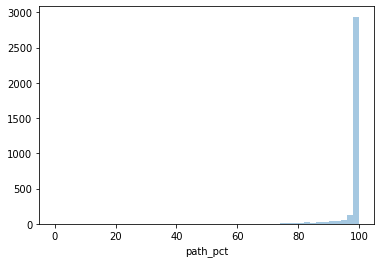

In [55]:
sns.distplot(summary['path_pct'].dropna(), kde=False)

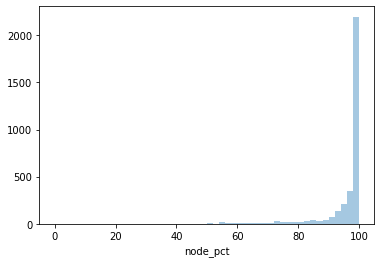

In [56]:
sns.distplot(summary['node_pct'].dropna(), kde=False)

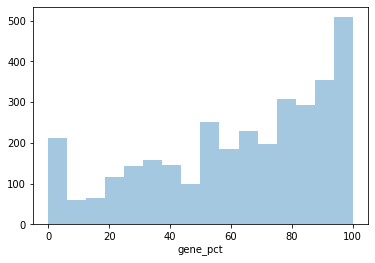

In [57]:
sns.distplot(summary['gene_pct'].dropna(), kde=False)

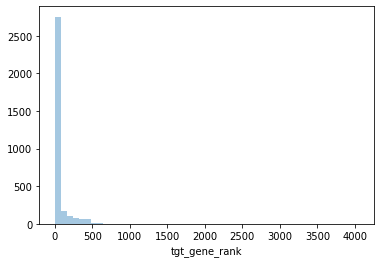

In [58]:
sns.distplot(summary['tgt_gene_rank'].dropna(), kde=False)

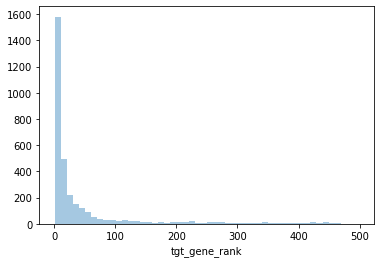

In [59]:
sns.distplot(summary.query('tgt_gene_rank < 500')['tgt_gene_rank'].dropna(), kde=False)

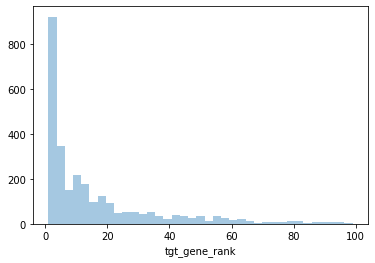

In [60]:
sns.distplot(summary.query('tgt_gene_rank < 100')['tgt_gene_rank'].dropna(), kde=False)

In [61]:
summary['tgt_gene_rank'].mean()

83.04273247065905

In [62]:
summary.query('tgt_gene_rank < 100')['tgt_gene_rank'].mean()

16.282756158514815

In [63]:
summary.query('gene_pct > 90')

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct
0,CHEBI:10033,DOID:0060224,warfarin,atrial fibrillation,NCBIGene:79001,VKORC1,1918792.0,305.0,4.0,14581.0,2.0,149.0,1.0,99.999792,99.986284,99.328859
16,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:762,CA4,5057.0,68.0,1.0,1258.0,2.0,13.0,1.0,99.980225,99.841017,92.307692
17,CHEBI:10112,DOID:219,zileuton,colon cancer,NCBIGene:240,ALOX5,715532.0,1347.0,3.0,11188.0,2.0,40.0,1.0,99.999581,99.982124,97.500000
18,CHEBI:10112,DOID:2841,zileuton,asthma,NCBIGene:240,ALOX5,601382.0,959.0,5.0,10567.0,5.0,40.0,2.0,99.999169,99.952683,95.000000
103,CHEBI:134716,DOID:5419,brexpiprazole,schizophrenia,NCBIGene:3356,HTR2A,23566.0,1468.0,2.0,1384.0,2.0,24.0,1.0,99.991513,99.855491,95.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,CHEBI:9927,DOID:6432,valsartan,pulmonary hypertension,NCBIGene:185,AGTR1,1217483.0,1124.0,16.0,11341.0,1.0,114.0,1.0,99.998686,99.991182,99.122807
3438,CHEBI:9943,DOID:10933,venlafaxine,obsessive-compulsive disorder,NCBIGene:6532,SLC6A4,154382.0,218.0,1.0,4629.0,1.0,183.0,1.0,99.999352,99.978397,99.453552
3442,CHEBI:9943,DOID:12849,venlafaxine,autistic disorder,NCBIGene:6532,SLC6A4,2355455.0,1118.0,78.0,14350.0,41.0,185.0,17.0,99.996689,99.714286,90.810811
3446,CHEBI:9943,DOID:2055,venlafaxine,post-traumatic stress disorder,NCBIGene:6532,SLC6A4,9040.0,54.0,87.0,1065.0,61.0,181.0,14.0,99.037611,94.272300,92.265193


In [64]:
t_paths = summary.count()['path_pct']
summary.query('highest_tgt_path <= 10').shape[0] / t_paths

0.2750526632560939

In [65]:
t_nodes = summary.count()['node_pct']
summary.query('tgt_node_rank <= 10').shape[0] / t_nodes

0.31714628297362113

In [66]:
t_genes = summary.count()['gene_pct']
summary.query('tgt_gene_rank <= 10').shape[0] / t_genes

0.47547396930484503

In [67]:
summary[summary['n_paths'].isnull()]

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct
110,CHEBI:135047,DOID:10612,phenyltoloxamine,allergic urticaria,NCBIGene:3269,HRH1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1551,CHEBI:4728,DOID:2841,dyphylline,asthma,NCBIGene:5142,PDE4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552,CHEBI:4728,DOID:2841,dyphylline,asthma,NCBIGene:5139,PDE3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1553,CHEBI:4728,DOID:6132,dyphylline,bronchitis,NCBIGene:5142,PDE4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1554,CHEBI:4728,DOID:6132,dyphylline,bronchitis,NCBIGene:5139,PDE3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1555,CHEBI:4728,DOID:9360,dyphylline,intrinsic asthma,NCBIGene:5142,PDE4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556,CHEBI:4728,DOID:9360,dyphylline,intrinsic asthma,NCBIGene:5139,PDE3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1557,CHEBI:4728,DOID:9415,dyphylline,allergic asthma,NCBIGene:5142,PDE4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1558,CHEBI:4728,DOID:9415,dyphylline,allergic asthma,NCBIGene:5139,PDE3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,CHEBI:59177,DOID:10612,bromazine,allergic urticaria,NCBIGene:3269,HRH1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
summary[~summary['n_paths'].isnull() & summary['tgt_node_rank'].isnull()]

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct
125,CHEBI:135529,DOID:8534,revaprazan,gastroesophageal reflux disease,NCBIGene:495,ATP4A,322.0,0.0,NaN,200.0,NaN,1.0,NaN,NaN,NaN,NaN
126,CHEBI:135529,DOID:8534,revaprazan,gastroesophageal reflux disease,NCBIGene:496,ATP4B,322.0,0.0,NaN,200.0,NaN,1.0,NaN,NaN,NaN,NaN
127,CHEBI:135544,DOID:219,ilaprazole,colon cancer,NCBIGene:495,ATP4A,6240.0,0.0,NaN,575.0,NaN,8.0,NaN,NaN,NaN,NaN
128,CHEBI:135544,DOID:219,ilaprazole,colon cancer,NCBIGene:496,ATP4B,6240.0,0.0,NaN,575.0,NaN,8.0,NaN,NaN,NaN,NaN
129,CHEBI:135544,DOID:750,ilaprazole,peptic ulcer disease,NCBIGene:495,ATP4A,497.0,0.0,NaN,133.0,NaN,8.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,CHEBI:9728,DOID:10763,trimethaphan,hypertension,NCBIGene:1143,CHRNB4,10780.0,0.0,NaN,1405.0,NaN,2.0,NaN,NaN,NaN,NaN
3424,CHEBI:9728,DOID:10763,trimethaphan,hypertension,NCBIGene:1136,CHRNA3,10780.0,0.0,NaN,1405.0,NaN,2.0,NaN,NaN,NaN,NaN
3439,CHEBI:9943,DOID:11257,venlafaxine,social phobia,NCBIGene:6530,SLC6A2,76.0,0.0,NaN,27.0,NaN,4.0,NaN,NaN,NaN,NaN
3440,CHEBI:9943,DOID:11257,venlafaxine,social phobia,NCBIGene:6532,SLC6A4,76.0,0.0,NaN,27.0,NaN,4.0,NaN,NaN,NaN,NaN


## Take the disease(s) highest in the Ontology for a drug-target pair

In [69]:
import obonet
import networkx as nx
doid = 'https://github.com/DiseaseOntology/HumanDiseaseOntology/raw/master/src/ontology/doid.obo'
graph = obonet.read_obo(doid)
len(graph)

10334

In [70]:
summary['dis_depth'] = summary['dis_id'].apply(lambda x: len(nx.descendants(graph, x)))

In [71]:
min_depth = summary.groupby(['comp_id', 'tgt_id'])['dis_depth'].min().to_frame().reset_index()
out = []

for row in min_depth.itertuples():
    cid = row.comp_id
    tid = row.tgt_id
    dpth = row.dis_depth
    
    out.append(summary.query('comp_id == @cid and tgt_id == @tid and dis_depth == @dpth'))
    
pd.concat(out)

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth
1,CHEBI:10033,DOID:6000,warfarin,congestive heart failure,NCBIGene:79001,VKORC1,1742777.0,374.0,219.0,14636.0,124.0,149.0,50.0,99.987434,99.152774,66.442953,4
2,CHEBI:10100,DOID:2841,zafirlukast,asthma,NCBIGene:10800,CYSLTR1,207231.0,672.0,24.0,7820.0,5.0,26.0,3.0,99.988419,99.936061,88.461538,5
14,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:759,CA1,5057.0,81.0,37.0,1258.0,26.0,13.0,13.0,99.268341,97.933227,0.000000,5
15,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:760,CA2,5057.0,112.0,4.0,1258.0,3.0,13.0,2.0,99.920902,99.761526,84.615385,5
16,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:762,CA4,5057.0,68.0,1.0,1258.0,2.0,13.0,1.0,99.980225,99.841017,92.307692,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,CHEBI:9943,DOID:594,venlafaxine,panic disorder,NCBIGene:6530,SLC6A2,680777.0,72.0,273.0,9203.0,155.0,183.0,60.0,99.959899,98.315767,67.213115,4
3438,CHEBI:9943,DOID:10933,venlafaxine,obsessive-compulsive disorder,NCBIGene:6532,SLC6A4,154382.0,218.0,1.0,4629.0,1.0,183.0,1.0,99.999352,99.978397,99.453552,4
3444,CHEBI:9943,DOID:14320,venlafaxine,generalized anxiety disorder,NCBIGene:6532,SLC6A4,1156.0,2.0,43.0,244.0,44.0,28.0,12.0,96.280277,81.967213,57.142857,4
3446,CHEBI:9943,DOID:2055,venlafaxine,post-traumatic stress disorder,NCBIGene:6532,SLC6A4,9040.0,54.0,87.0,1065.0,61.0,181.0,14.0,99.037611,94.272300,92.265193,4


In [72]:
summary_filt = pd.concat(out, ignore_index=True, sort=False)

In [73]:
summary_filt.count()

comp_id             1124
dis_id              1124
comp_name           1124
dis_name            1124
tgt_id              1124
tgt_name            1124
n_paths             1116
n_tgt_paths         1116
highest_tgt_path    1060
total_nodes         1116
tgt_node_rank       1072
n_tgt_genes         1116
tgt_gene_rank       1060
path_pct            1060
node_pct            1072
gene_pct            1060
dis_depth           1124
dtype: int64

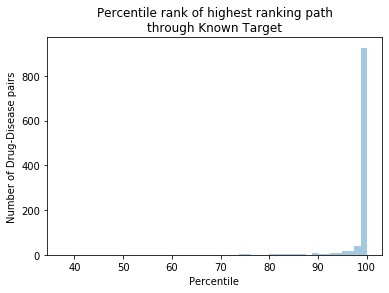

In [102]:
sns.distplot(summary_filt['path_pct'].dropna(), kde=False)
plt.xlabel('Percentile')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Percentile rank of highest ranking path\nthrough Known Target');

In [110]:
summary_filt[['highest_tgt_path', 'n_paths']].describe()

,highest_tgt_path,n_paths
count,1060.000000,1.116000e+03
mean,363.686792,6.781449e+05
std,1330.796706,1.294550e+06
min,1.000000,4.000000e+00
25%,4.000000,2.799000e+03
50%,20.000000,5.522950e+04
75%,106.000000,4.493505e+05
max,15601.000000,1.049979e+07


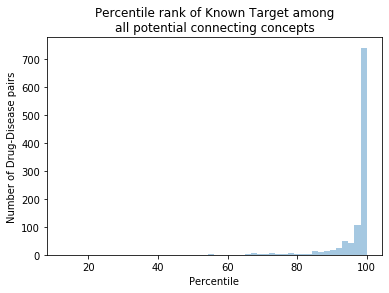

In [103]:
sns.distplot(summary_filt['node_pct'].dropna(), kde=False)
plt.xlabel('Percentile')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Percentile rank of Known Target among\nall potential connecting concepts');

In [111]:
summary_filt[['tgt_node_rank', 'total_nodes']].describe()

,tgt_node_rank,total_nodes
count,1072.000000,1116.000000
mean,137.755597,5555.387993
std,424.511200,5714.379796
min,1.000000,5.000000
25%,3.000000,571.000000
50%,15.000000,3664.000000
75%,76.000000,8466.000000
max,6375.000000,23603.000000


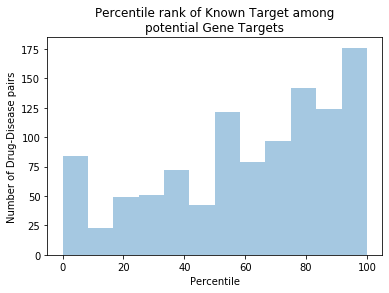

In [105]:
sns.distplot(summary_filt['gene_pct'].dropna(), kde=False)
plt.xlabel('Percentile')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Percentile rank of Known Target among\npotential Gene Targets');

In [113]:
summary_filt[['tgt_gene_rank', 'n_tgt_genes']].describe()

,tgt_gene_rank,n_tgt_genes
count,1060.000000,1116.000000
mean,58.618868,262.803763
std,203.245192,911.784021
min,1.000000,0.000000
25%,2.000000,6.000000
50%,6.000000,26.000000
75%,25.000000,100.000000
max,2469.000000,12865.000000


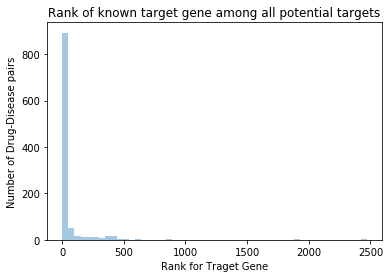

In [107]:
sns.distplot(summary_filt['tgt_gene_rank'].dropna(), kde=False)
plt.xlabel('Rank for Traget Gene')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Rank of known target gene among all potential targets');

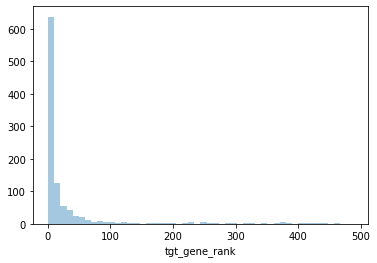

In [78]:
sns.distplot(summary_filt.query('tgt_gene_rank < 500')['tgt_gene_rank'].dropna(), kde=False);

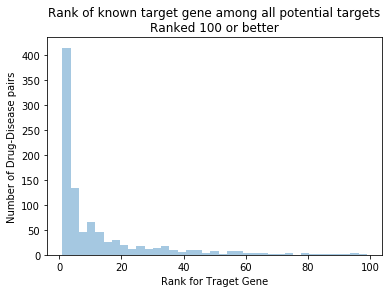

In [108]:
sns.distplot(summary_filt.query('tgt_gene_rank < 100')['tgt_gene_rank'].dropna(), kde=False)
plt.xlabel('Rank for Traget Gene')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Rank of known target gene among all potential targets\nRanked 100 or better');

In [80]:
t_paths = summary_filt.count()['path_pct']
summary_filt.query('highest_tgt_path <= 10').shape[0] / t_paths

0.3877358490566038

In [81]:
t_nodes = summary_filt.count()['node_pct']
summary_filt.query('tgt_node_rank <= 10').shape[0] / t_nodes

0.4449626865671642

In [114]:
t_genes = summary_filt.count()['gene_pct']
summary_filt.query('tgt_gene_rank <= 10').shape[0] / t_genes

0.6009433962264151

In [115]:
summary_filt.query('tgt_gene_rank <= 10').shape[0], t_genes

(637, 1060)

In [95]:
summary_filt[['n_tgt_genes', 'tgt_gene_rank']].describe()

,n_tgt_genes,tgt_gene_rank
count,1116.000000,1060.000000
mean,262.803763,58.618868
std,911.784021,203.245192
min,0.000000,1.000000
25%,6.000000,2.000000
50%,26.000000,6.000000
75%,100.000000,25.000000
max,12865.000000,2469.000000


### What top # cutoff do we need to get 90% of targets?

In [83]:
t_genes = summary_filt.count()['gene_pct']
summary_filt.query('tgt_gene_rank <= 50').shape[0] / t_genes

0.8415094339622642

In [84]:
t_genes = summary_filt.count()['gene_pct']
summary_filt.query('tgt_gene_rank <= 100').shape[0] / t_genes

0.8905660377358491

In [85]:
t_genes = summary_filt.count()['gene_pct']
summary_filt.query('tgt_gene_rank <= 500').shape[0] / t_genes

0.9830188679245283

In [86]:
summary_filt.query('tgt_gene_rank > 100')

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth
117,CHEBI:15367,DOID:37,all-trans-retinoic acid,skin disease,NCBIGene:5914,RARA,5155611.0,975.0,1470.0,18668.0,596.0,5214.0,193.0,99.971487,96.807371,96.298427,3
118,CHEBI:15367,DOID:8866,all-trans-retinoic acid,actinic keratosis,NCBIGene:5914,RARA,113880.0,27.0,5893.0,5321.0,1677.0,3810.0,1310.0,94.825255,68.483368,65.616798,3
119,CHEBI:15367,DOID:9120,all-trans-retinoic acid,amyloidosis,NCBIGene:5914,RARA,1046248.0,158.0,14551.0,14319.0,3065.0,5104.0,2034.0,98.609221,78.594874,60.148903,3
120,CHEBI:15367,DOID:37,all-trans-retinoic acid,skin disease,NCBIGene:5915,RARB,5155611.0,713.0,5600.0,18668.0,1723.0,5214.0,841.0,99.891380,90.770302,83.870349,3
121,CHEBI:15367,DOID:8866,all-trans-retinoic acid,actinic keratosis,NCBIGene:5915,RARB,113880.0,18.0,15601.0,5321.0,2870.0,3810.0,2423.0,86.300492,46.062770,36.404199,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,CHEBI:72690,DOID:9120,pomalidomide,amyloidosis,NCBIGene:51185,CRBN,538830.0,18.0,340.0,10406.0,488.0,483.0,225.0,99.936900,95.310398,53.416149,3
948,CHEBI:80630,DOID:10534,irinotecan,stomach cancer,NCBIGene:7150,TOP1,4106955.0,902.0,3123.0,18180.0,1455.0,645.0,519.0,99.923958,91.996700,19.534884,8
949,CHEBI:80630,DOID:1612,irinotecan,breast cancer,NCBIGene:7150,TOP1,4669919.0,1447.0,3642.0,19509.0,1359.0,645.0,505.0,99.922011,93.033984,21.705426,8
1064,CHEBI:91583,DOID:9784,"2-[cyclohexyl(oxo)methyl]-3,6,7,11b-tetrahydro...",trichinosis,UniProt:Q95US7,high voltage-activated calcium channel beta su...,165315.0,5.0,473.0,3058.0,294.0,316.0,159.0,99.713880,90.385873,49.683544,4


# Look at a few specific Examples

In [116]:
summary_filt.query('tgt_gene_rank == 1')

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth
4,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:762,CA4,5057.0,68.0,1.0,1258.0,2.0,13.0,1.0,99.980225,99.841017,92.307692,5
22,CHEBI:133013,DOID:1826,brivaracetam,epilepsy,NCBIGene:9900,SV2A,453.0,453.0,1.0,328.0,1.0,1.0,1.0,99.779249,99.695122,0.000000,5
23,CHEBI:133021,DOID:9119,venetoclax,acute myeloid leukemia,NCBIGene:596,BCL2,4355.0,2302.0,1.0,762.0,1.0,3.0,1.0,99.977038,99.868766,66.666667,9
25,CHEBI:133023,DOID:10140,lifitegrast,dry eye syndrome,NCBIGene:3689,ITGB2,280.0,118.0,4.0,105.0,1.0,3.0,1.0,98.571429,99.047619,66.666667,6
31,CHEBI:134677,DOID:3777,crisaborole,granuloma annulare,NCBIGene:5143,PDE4C,31.0,6.0,1.0,11.0,4.0,6.0,1.0,96.774194,63.636364,83.333333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,CHEBI:9701,DOID:10808,tridihexethyl,gastric ulcer,NCBIGene:1128,CHRM1,1288.0,412.0,1.0,239.0,1.0,3.0,1.0,99.922360,99.581590,66.666667,4
1107,CHEBI:9725,DOID:1558,Trimeprazine,angioedema,NCBIGene:3269,HRH1,295.0,196.0,3.0,133.0,1.0,3.0,1.0,98.983051,99.248120,66.666667,4
1108,CHEBI:9727,DOID:1826,Trimethadione,epilepsy,NCBIGene:8913,CACNA1G,1827.0,544.0,1.0,277.0,1.0,3.0,1.0,99.945265,99.638989,66.666667,5
1115,CHEBI:9927,DOID:6000,valsartan,congestive heart failure,NCBIGene:185,AGTR1,2185213.0,2116.0,11.0,12964.0,1.0,114.0,1.0,99.999497,99.992286,99.122807,4


In [123]:
def get_idx_info(idx):

    cid = summary_filt.loc[idx, 'comp_id']
    did = summary_filt.loc[idx, 'dis_id']
    tgt = summary_filt.loc[idx, 'tgt_id']
    
    return cid, did, tgt

In [131]:
def calc_idx_paths(idx):
    cid, did, tgt = get_idx_info(idx)

    try:
        paths = get_path_info(cid, did, 30)
    except:
        paths = get_path_info(cid, did, 1)
    return paths

In [126]:
def load_node_ranks(idx):
    cid, did, tgt = get_idx_info(idx)

    node_ranks = pd.read_csv(out_dir.joinpath('{}_{}_node_ranks.csv'.format(cid.replace(':', '_'), did.replace(':', '_'))))
    return node_ranks

In [134]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [ ]:
gp.draw_explanitory_graph()

In [220]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=len(list_of_paths));

In [223]:
import warnings
warnings.simplefilter('ignore')

In [224]:
sns.set_palette('muted')

In [225]:
idx = 1104
tri_gu_paths = calc_idx_paths(idx)
tri_gu_nodes = load_node_ranks(idx)
cid, did, tgt = get_idx_info(idx)

100%|██████████| 89/89 [00:00<00:00, 92.65it/s] 


In [226]:
tgt_paths = query_target(tri_gu_paths, tgt)

In [227]:
tri_gu_nodes.query('deg_sep == 1')

,node_id,model_metric,deg_sep,node_name,node_label
0,NCBIGene:1128,1.384852,1,CHRM1,MacromolecularMachine
1,NCBIGene:1129,0.932834,1,CHRM2,MacromolecularMachine
2,NCBIGene:1131,0.911933,1,CHRM3,MacromolecularMachine


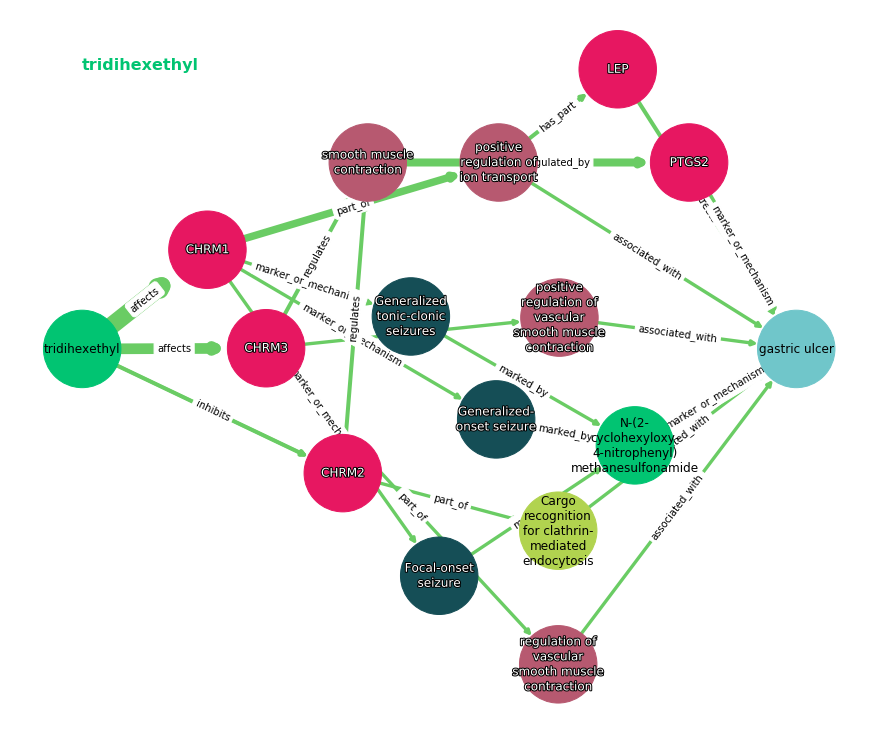

In [228]:
draw_top_paths(tri_gu_paths)

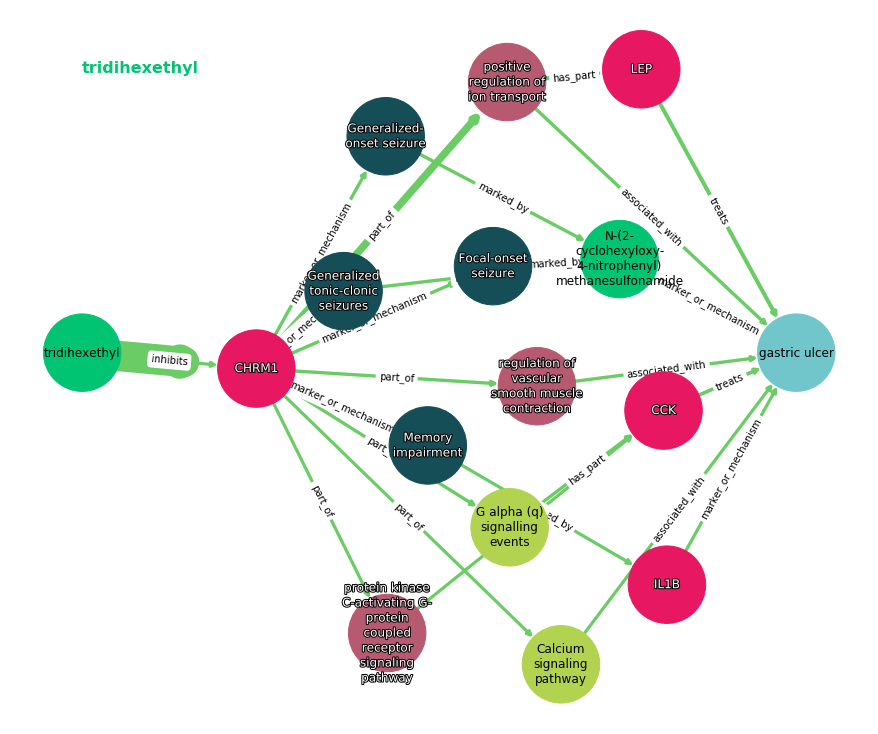

In [229]:
draw_top_paths(query_target(tri_gu_paths, tgt))

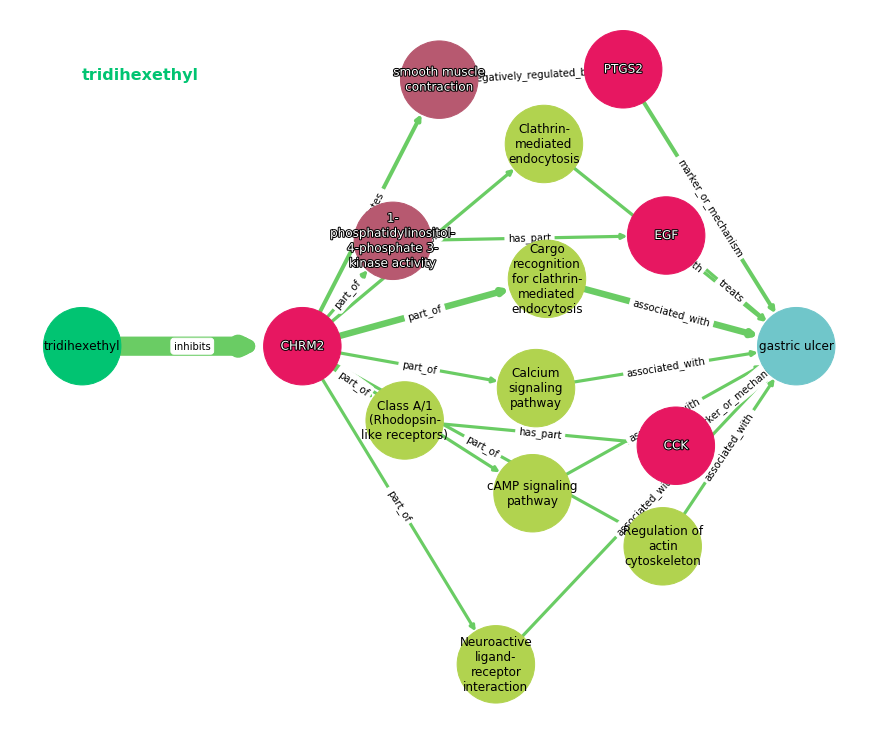

In [230]:
draw_top_paths(query_target(tri_gu_paths, 'NCBIGene:1129'))

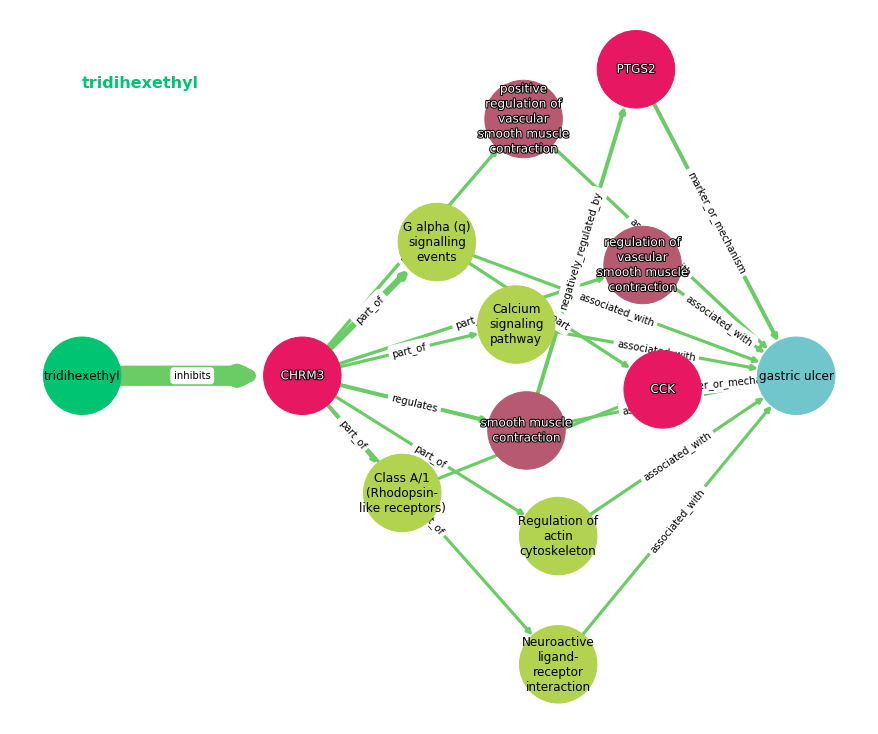

In [231]:
draw_top_paths(query_target(tri_gu_paths, 'NCBIGene:1131'))

### venlafaxine 	obsessive-compulsive disorder

In [150]:
idx = 1120
cen_ocd_paths = calc_idx_paths(idx)
cid, did, tgt = get_idx_info(idx)

100%|██████████| 89/89 [00:09<00:00,  9.50it/s]


In [151]:
ven_ocd_nodes = load_node_ranks(idx)

In [200]:
len(ven_ocd_nodes)

4629

In [193]:
ven_ocd_nodes.head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,NCBIGene:6532,2.043701,1,SLC6A4,MacromolecularMachine
1,CHEBI:16581,1.303525,2,pregnenolone,ChemicalSubstance
2,NCBIGene:1586,1.274477,1,CYP17A1,MacromolecularMachine
3,GO:0032278,1.132436,1,positive regulation of gonadotropin secretion,BiologicalProcessOrActivity
4,GO:0060143,1.115854,1,positive regulation of syncytium formation by ...,BiologicalProcessOrActivity
5,GO:0032769,1.045527,1,negative regulation of monooxygenase activity,BiologicalProcessOrActivity
6,HP:0000975,0.964041,2,Hyperhidrosis,PhenotypicFeature
7,GO:0051350,0.938532,1,negative regulation of lyase activity,BiologicalProcessOrActivity
8,CHEBI:86990,0.849219,3,N-methyl-3-phenyl-3-[4-(trifluoromethyl)phenox...,ChemicalSubstance
9,WP:WP706,0.690509,2,Sudden Infant Death Syndrome (SIDS) Susceptibi...,Pathway


In [155]:
ven_ocd_nodes.query('deg_sep == 1 and node_label == "MacromolecularMachine"').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,NCBIGene:6532,2.043701,1,SLC6A4,MacromolecularMachine
2,NCBIGene:1586,1.274477,1,CYP17A1,MacromolecularMachine
13,NCBIGene:1565,0.500345,1,CYP2D6,MacromolecularMachine
17,NCBIGene:3350,0.444651,1,HTR1A,MacromolecularMachine
20,NCBIGene:3351,0.416829,1,HTR1B,MacromolecularMachine
23,NCBIGene:3358,0.375929,1,HTR2C,MacromolecularMachine
25,NCBIGene:6015,0.350861,1,RING1,MacromolecularMachine
29,NCBIGene:23237,0.277485,1,ARC,MacromolecularMachine
30,NCBIGene:429,0.274020,1,ASCL1,MacromolecularMachine
32,NCBIGene:3360,0.267862,1,HTR4,MacromolecularMachine


In [194]:
len(ven_ocd_nodes.query('deg_sep == 1 and node_label == "MacromolecularMachine"'))

183

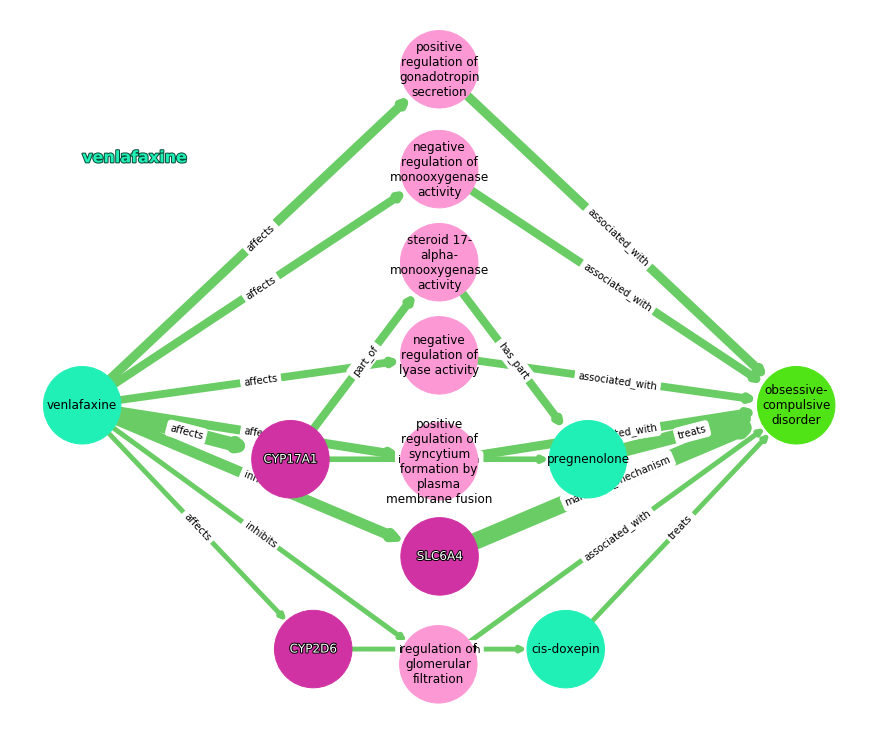

In [156]:
draw_top_paths(cen_ocd_paths)

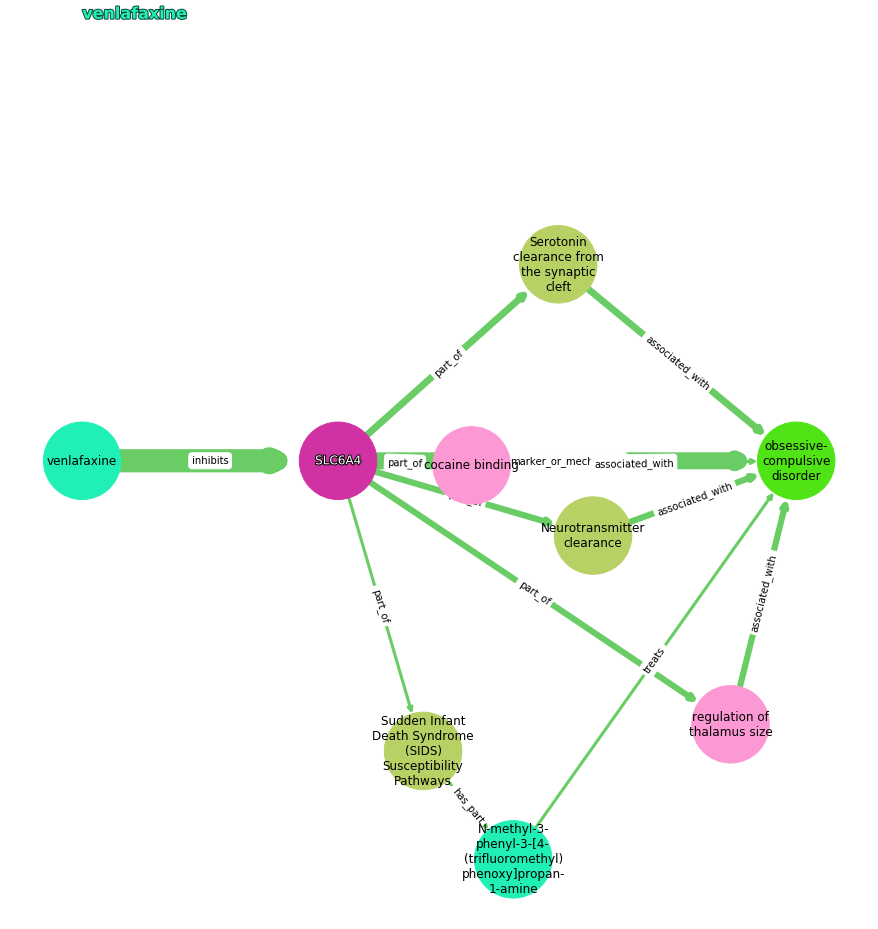

In [157]:
draw_top_paths(query_target(cen_ocd_paths, tgt))

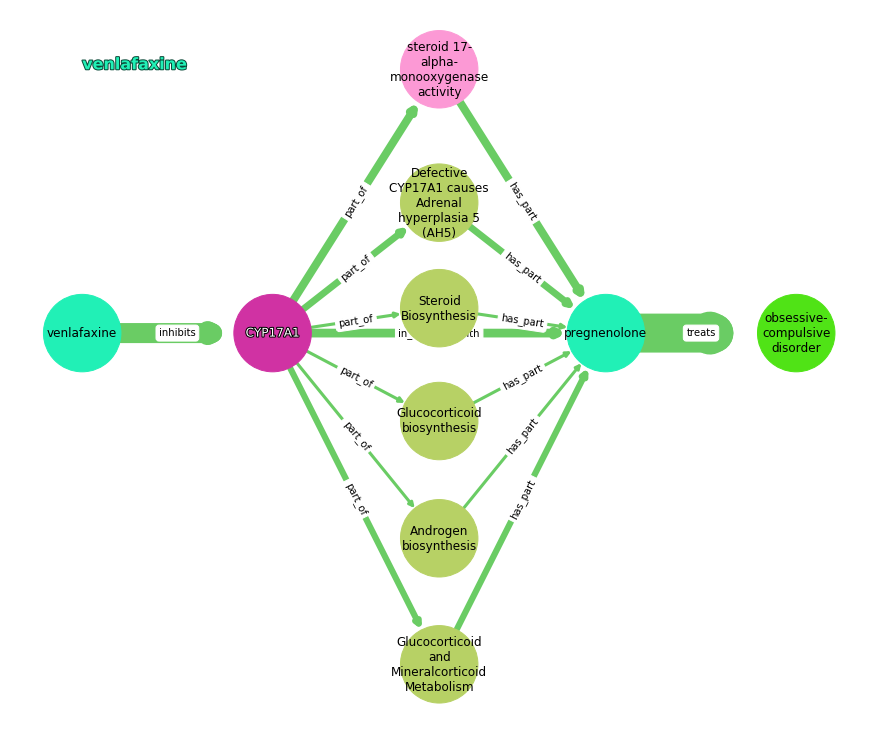

In [158]:
draw_top_paths(query_target(cen_ocd_paths, 'NCBIGene:1586'))

In [160]:
summary_filt.query('tgt_gene_rank != 1 and tgt_gene_rank <= 10').sample(20)

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth
582,CHEBI:51364,DOID:3312,zuclopenthixol,bipolar disorder,NCBIGene:1812,DRD1,6673.0,926.0,4.0,607.0,2.0,10.0,2.0,99.940057,99.670511,80.000000,4
609,CHEBI:5801,DOID:12919,hydroxychloroquine,Plasmodium ovale malaria,NCBIGene:51284,TLR7,620.0,45.0,41.0,268.0,31.0,13.0,5.0,93.387097,88.432836,61.538462,5
1002,CHEBI:8461,DOID:2951,promethazine,motion sickness,NCBIGene:3269,HRH1,1128.0,35.0,23.0,381.0,14.0,42.0,3.0,97.960993,96.325459,92.857143,6
1040,CHEBI:90930,DOID:5419,aripiprazole lauroxil,schizophrenia,NCBIGene:1813,DRD2,22521.0,1495.0,2.0,1039.0,2.0,25.0,2.0,99.991119,99.807507,92.000000,4
105,CHEBI:142290,DOID:1588,anagrelide,thrombocytopenia,NCBIGene:5139,PDE3A,62832.0,279.0,12.0,2938.0,9.0,12.0,7.0,99.980901,99.693669,41.666667,5
578,CHEBI:5125,DOID:5419,Fluphenazine enanthate,schizophrenia,NCBIGene:1813,DRD2,23298.0,1792.0,10.0,1067.0,2.0,27.0,2.0,99.957078,99.812559,92.592593,4
21,CHEBI:125354,DOID:9119,"1-[[4-(1,4,8,11-tetrazacyclotetradec-1-ylmethy...",acute myeloid leukemia,NCBIGene:7852,CXCR4,433876.0,1301.0,19.0,7540.0,7.0,14.0,3.0,99.995621,99.907162,78.571429,9
984,CHEBI:84116,DOID:3310,triprolidine,atopic dermatitis,NCBIGene:3269,HRH1,69560.0,425.0,3.0,3781.0,3.0,10.0,2.0,99.995687,99.920656,80.000000,9
978,CHEBI:83766,DOID:2671,olaparib,transitional cell carcinoma,NCBIGene:10039,PARP3,199295.0,85.0,4.0,4135.0,4.0,5.0,4.0,99.997993,99.903265,20.000000,5
1048,CHEBI:90942,DOID:9120,ixazomib,amyloidosis,NCBIGene:5693,PSMB5,637.0,149.0,10.0,132.0,4.0,4.0,3.0,98.430141,96.969697,25.000000,3


## anagrelide 	thrombocytopenia

In [162]:
idx = 105
ana_thr_paths = calc_idx_paths(idx)
ana_thr_nodes = load_node_ranks(idx)
cid, did, tgt = get_idx_info(idx)

100%|██████████| 89/89 [00:03<00:00, 24.74it/s] 


In [166]:
tgt

'NCBIGene:5139'

In [165]:
ana_thr_nodes.head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,NCBIGene:2623,2.012600,1,GATA1,MacromolecularMachine
1,NCBIGene:3674,1.727713,1,ITGA2B,MacromolecularMachine
2,REACT:R-HSA-109582,1.516464,1,hemostasis,Pathway
3,NCBIGene:161882,1.047541,1,ZFPM1,MacromolecularMachine
4,NCBIGene:7040,1.044175,1,TGFB1,MacromolecularMachine
5,CHEBI:32106,0.999208,3,Romurtide,ChemicalSubstance
6,NCBIGene:4352,0.870854,1,MPL,MacromolecularMachine
7,NCBIGene:7066,0.750266,1,THPO,MacromolecularMachine
8,NCBIGene:5139,0.708759,1,PDE3A,MacromolecularMachine
9,NCBIGene:3562,0.647197,2,IL3,MacromolecularMachine


In [171]:
ana_thr_nodes.query('deg_sep == 1 and node_label == "MacromolecularMachine"')

,node_id,model_metric,deg_sep,node_name,node_label
0,NCBIGene:2623,2.012600,1,GATA1,MacromolecularMachine
1,NCBIGene:3674,1.727713,1,ITGA2B,MacromolecularMachine
3,NCBIGene:161882,1.047541,1,ZFPM1,MacromolecularMachine
4,NCBIGene:7040,1.044175,1,TGFB1,MacromolecularMachine
6,NCBIGene:4352,0.870854,1,MPL,MacromolecularMachine
7,NCBIGene:7066,0.750266,1,THPO,MacromolecularMachine
8,NCBIGene:5139,0.708759,1,PDE3A,MacromolecularMachine
11,NCBIGene:5140,0.437416,1,PDE3B,MacromolecularMachine
16,NCBIGene:1544,0.313442,1,CYP1A2,MacromolecularMachine
21,NCBIGene:5155,0.231945,1,PDGFB,MacromolecularMachine


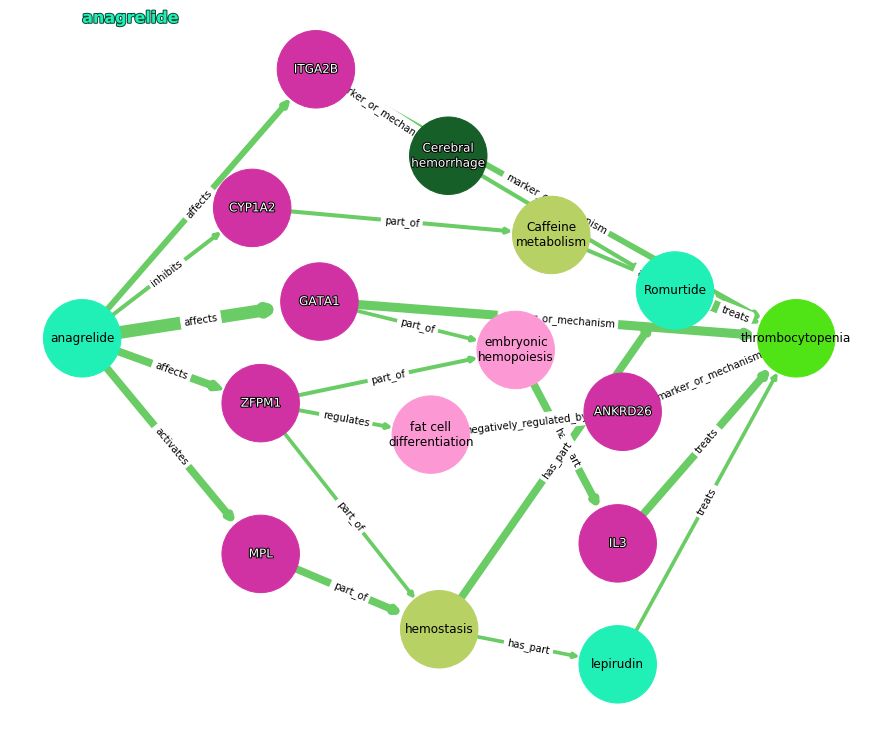

In [167]:
draw_top_paths(ana_thr_paths)

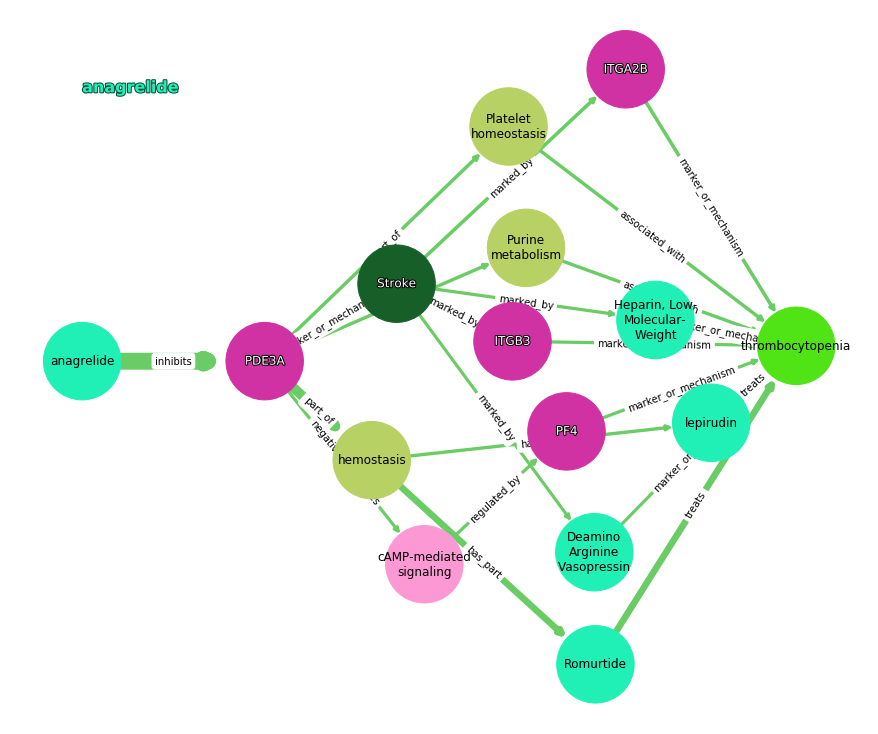

In [168]:
draw_top_paths(query_target(ana_thr_paths, tgt))

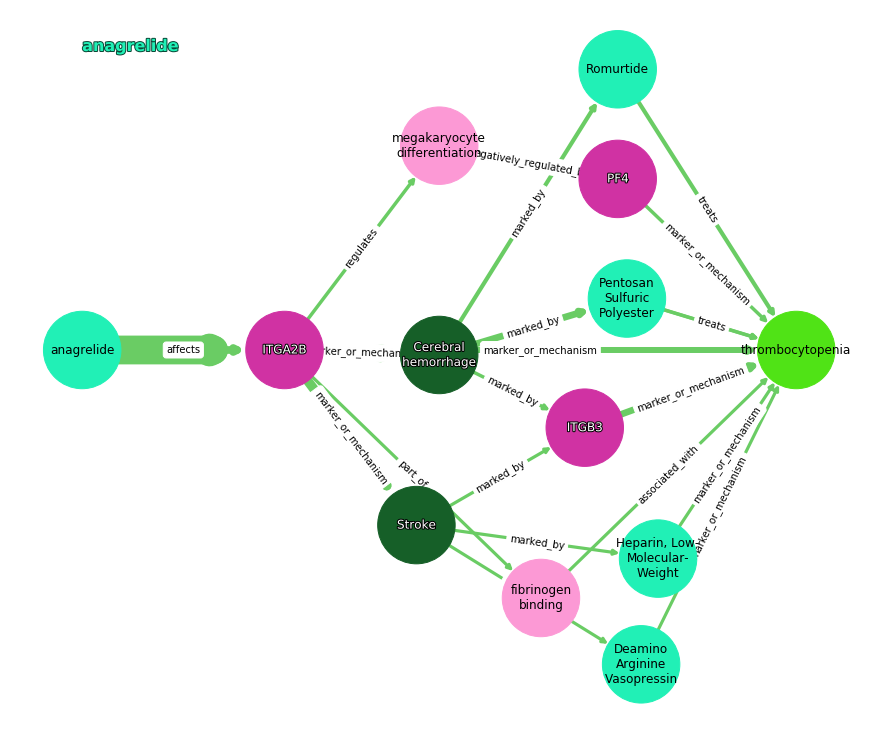

In [169]:
draw_top_paths(query_target(ana_thr_paths, 'NCBIGene:3674'))

## 6-propyl-2-thiouracil 	hyperthyroidism

In [173]:
idx = 1013
prt_hyp_paths = calc_idx_paths(idx)
prt_hyp_nodes = load_node_ranks(idx)
cid, did, tgt = get_idx_info(idx)

100%|██████████| 89/89 [00:45<00:00,  1.97it/s]


In [174]:
tgt

'NCBIGene:7173'

In [177]:
prt_hyp_nodes.head(12)

,node_id,model_metric,deg_sep,node_name,node_label
0,WP:WP1981,2.357626,2,Thyroxine (Thyroid Hormone) Production,Pathway
1,IKEY:XMBWDFGMSWQBCA-RNFDNDRNSA-M,2.213544,3,iodide ion i-131,ChemicalSubstance
2,NCBIGene:9607,1.356559,1,CARTPT,MacromolecularMachine
3,NCBIGene:7038,1.083301,1,TG,MacromolecularMachine
4,GO:0021954,0.769473,1,central nervous system neuron development,BiologicalProcessOrActivity
5,GO:0036093,0.722084,1,germ cell proliferation,BiologicalProcessOrActivity
6,GO:0021884,0.663873,1,forebrain neuron development,BiologicalProcessOrActivity
7,NCBIGene:7253,0.607013,1,TSHR,MacromolecularMachine
8,NCBIGene:358,0.514502,1,AQP1,MacromolecularMachine
9,GO:0001580,0.512227,1,detection of chemical stimulus involved in sen...,BiologicalProcessOrActivity


In [176]:
prt_hyp_nodes.query('deg_sep == 1 and node_label == "MacromolecularMachine"').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
2,NCBIGene:9607,1.356559,1,CARTPT,MacromolecularMachine
3,NCBIGene:7038,1.083301,1,TG,MacromolecularMachine
7,NCBIGene:7253,0.607013,1,TSHR,MacromolecularMachine
8,NCBIGene:358,0.514502,1,AQP1,MacromolecularMachine
11,NCBIGene:7173,0.415436,1,TPO,MacromolecularMachine
13,NCBIGene:7200,0.367609,1,TRH,MacromolecularMachine
16,NCBIGene:2876,0.306358,1,GPX1,MacromolecularMachine
21,NCBIGene:5444,0.217477,1,PON1,MacromolecularMachine
24,NCBIGene:847,0.176155,1,CAT,MacromolecularMachine
25,NCBIGene:6528,0.173120,1,SLC5A5,MacromolecularMachine


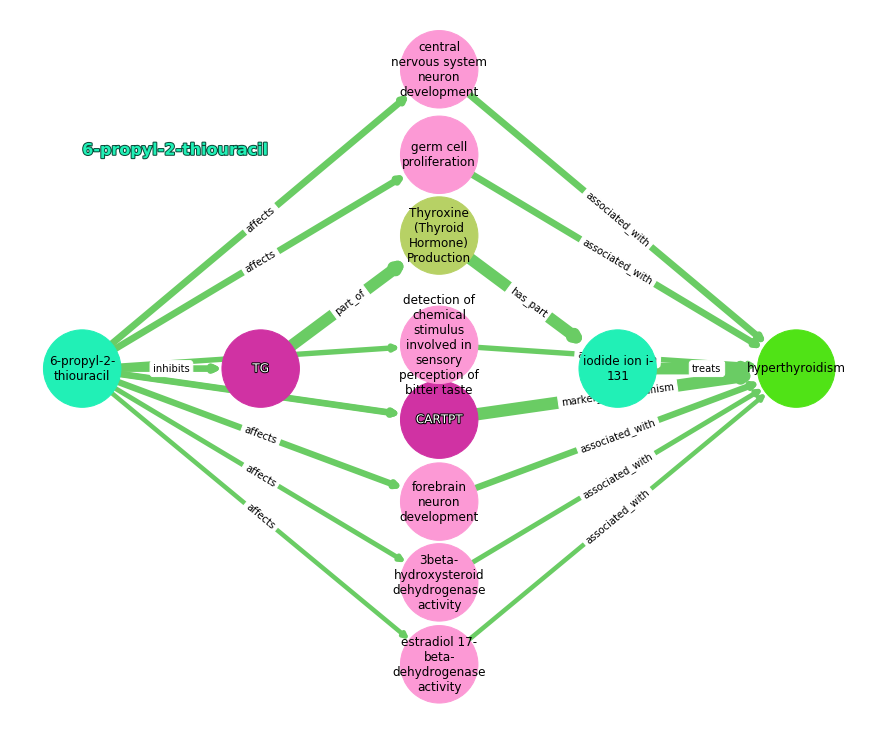

In [179]:
draw_top_paths(prt_hyp_paths)

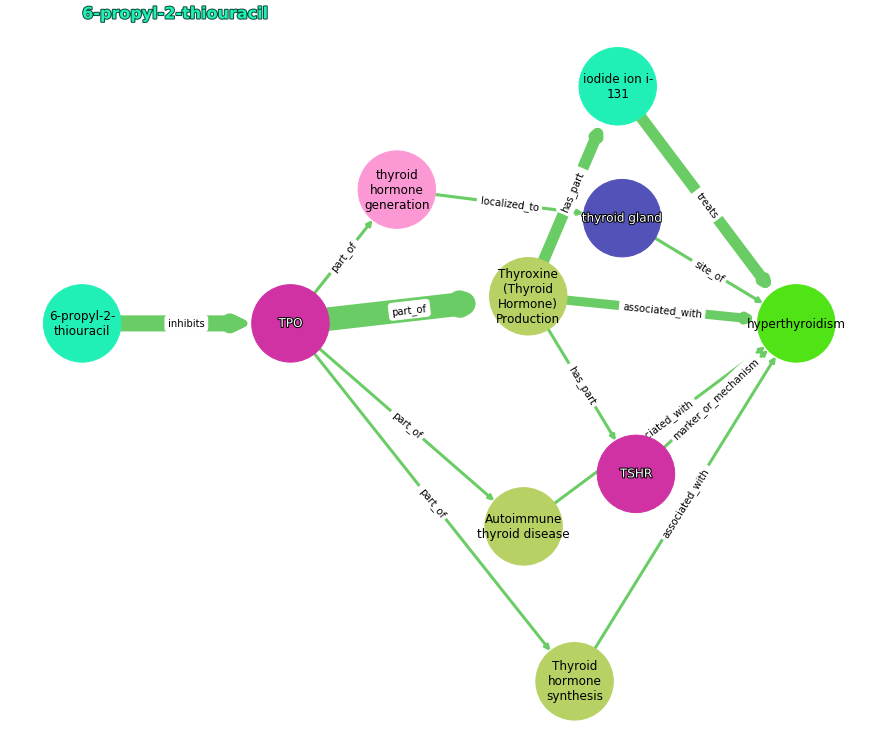

In [181]:
draw_top_paths(query_target(prt_hyp_paths, tgt))

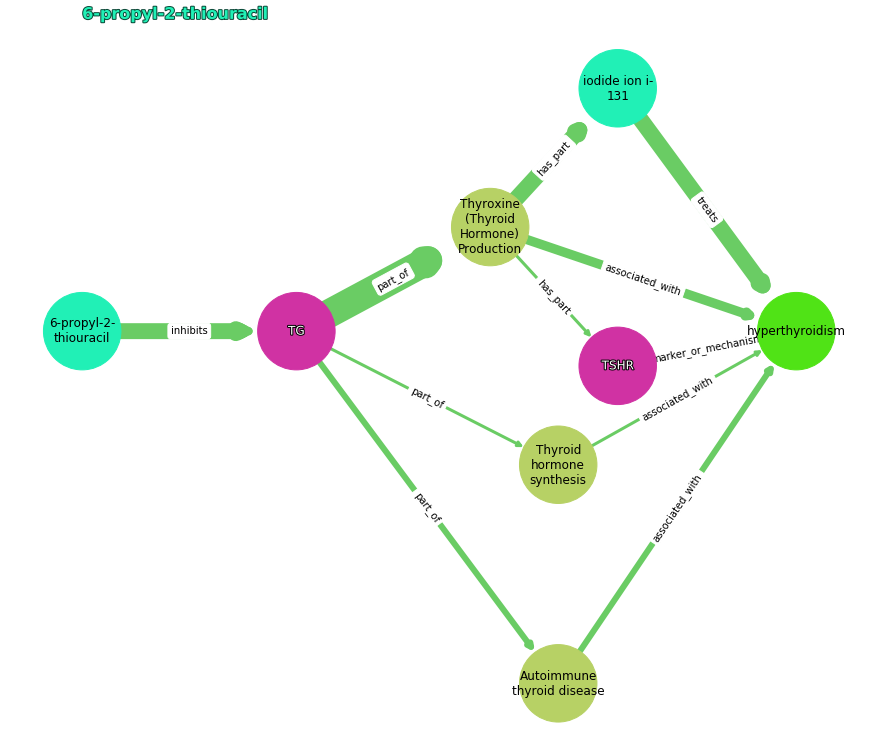

In [182]:
draw_top_paths(query_target(prt_hyp_paths, 'NCBIGene:7038'))

In [190]:
len(summary_filt.query('comp_id == "CHEBI:6801" and dis_id == "DOID:9352"'))

50

In [189]:
summary_filt.query('comp_id == "CHEBI:6801" and dis_id == "DOID:9352"').sort_values('tgt_node_rank').head()

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth
770,CHEBI:6801,DOID:9352,metformin,type 2 diabetes mellitus,NCBIGene:4540,ND5,3623276.0,393.0,191.0,17136.0,291.0,560.0,111.0,99.994729,98.301821,80.178571,6
771,CHEBI:6801,DOID:9352,metformin,type 2 diabetes mellitus,NCBIGene:4541,ND6,3623276.0,319.0,206.0,17136.0,307.0,560.0,118.0,99.994315,98.208450,78.928571,6
768,CHEBI:6801,DOID:9352,metformin,type 2 diabetes mellitus,NCBIGene:4538,ND4,3623276.0,431.0,171.0,17136.0,309.0,560.0,120.0,99.995281,98.196779,78.571429,6
765,CHEBI:6801,DOID:9352,metformin,type 2 diabetes mellitus,NCBIGene:4535,ND1,3623276.0,548.0,254.0,17136.0,333.0,560.0,134.0,99.992990,98.056723,76.071429,6
810,CHEBI:6801,DOID:9352,metformin,type 2 diabetes mellitus,NCBIGene:91942,NDUFAF2,3623276.0,146.0,496.0,17136.0,407.0,560.0,172.0,99.986311,97.624883,69.285714,6


## metformin 	type 2 diabetes mellitus 	

In [192]:
idx = 770
met_t2d_paths = calc_idx_paths(idx)
met_t2d_nodes = load_node_ranks(idx)
cid, did, tgt = get_idx_info(idx)

100%|██████████| 89/89 [02:33<00:00,  1.73s/it]


In [195]:
met_t2d_nodes.head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,CHEBI:16196,1.248621,2,oleic acid,ChemicalSubstance
1,CHEBI:36276,1.219504,2,sodium taurocholate,ChemicalSubstance
2,HP:0000855,1.030842,2,Insulin resistance,PhenotypicFeature
3,NCBIGene:3952,0.992685,1,LEP,MacromolecularMachine
4,CHEBI:9254,0.975845,2,magnesium distearate,ChemicalSubstance
5,CHEBI:8229,0.886825,2,Pioglitazone hydrochloride,ChemicalSubstance
6,NCBIGene:2641,0.808398,1,GCG,MacromolecularMachine
7,MESH:D013453,0.798554,3,Sulfonylurea Compounds,ChemicalSubstance
8,GO:1904184,0.596132,1,positive regulation of pyruvate dehydrogenase ...,BiologicalProcessOrActivity
9,CHEBI:27997,0.516025,2,elaidic acid,ChemicalSubstance


In [197]:
pairs.query('chemicalsubstance_id == @cid and disease_id == @did')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,dc_status
95604,CHEBI:6801,DOID:9352,0.504745,metformin,type 2 diabetes mellitus,1,1


In [199]:
met_t2d_nodes.query('node_id == @tgt')

,node_id,model_metric,deg_sep,node_name,node_label
290,NCBIGene:4540,0.030052,1,ND5,MacromolecularMachine


In [201]:
len(met_t2d_nodes)

17136

In [205]:
met_t2d_nodes.query('deg_sep == 1 and node_label == "MacromolecularMachine"').reset_index(drop=True).query('node_id == @tgt')

,node_id,model_metric,deg_sep,node_name,node_label
110,NCBIGene:4540,0.030052,1,ND5,MacromolecularMachine


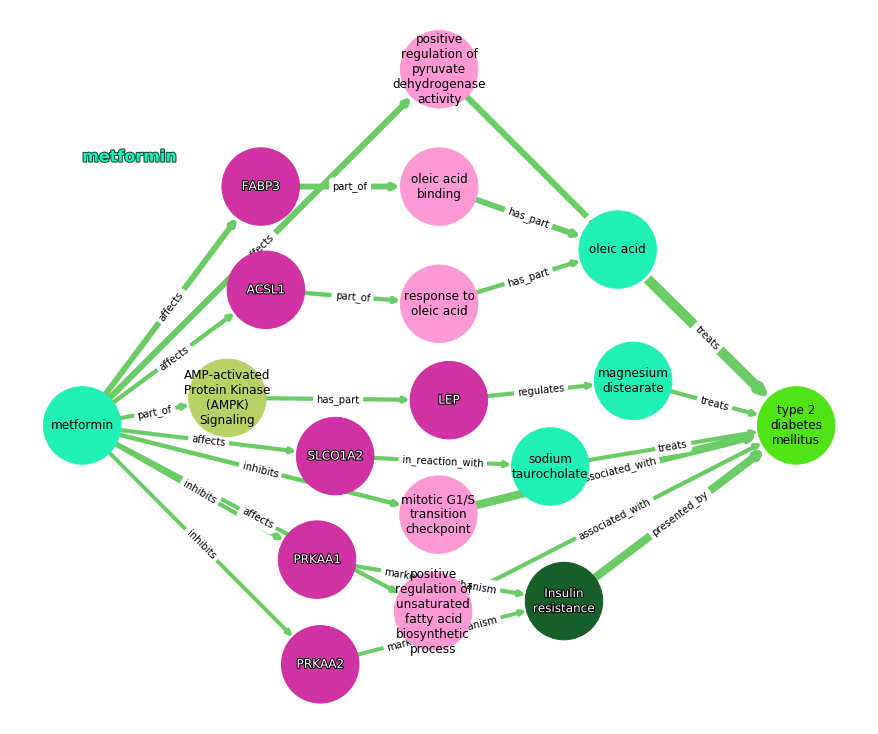

In [207]:
draw_top_paths(met_t2d_paths)

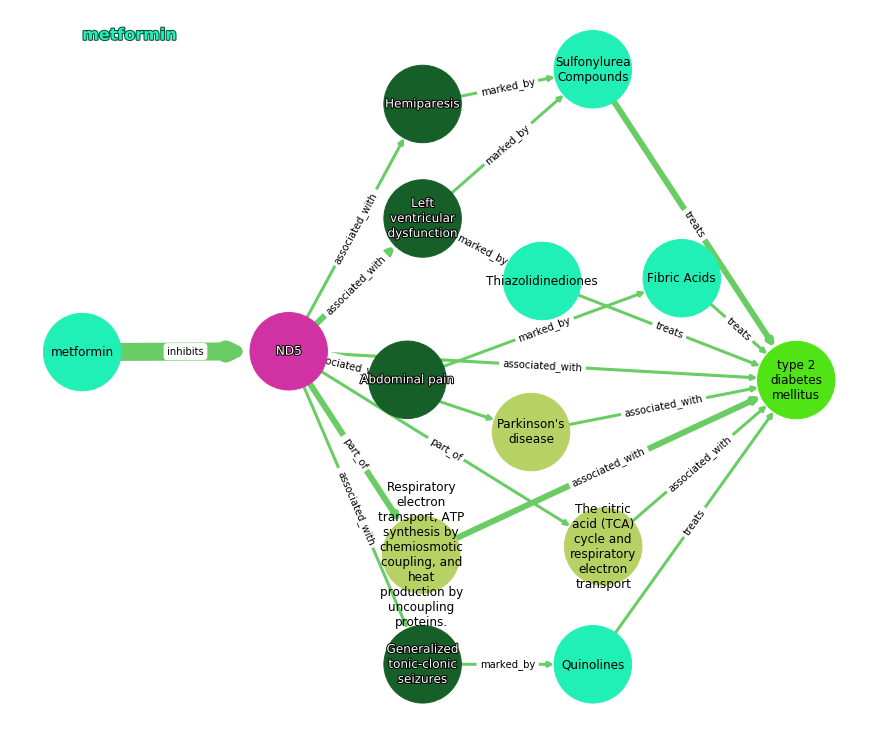

In [208]:
draw_top_paths(query_target(met_t2d_paths, tgt))

In [212]:
met_t2d_nodes.query('node_id == "REACT:R-HSA-6799192"')

,node_id,model_metric,deg_sep,node_name,node_label


In [211]:
nodes[nodes['name'].str.contains('omplex I')].query('label == "MacromolecularMachine"')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
20232,REACT:R-CEL-164304,Complex III - Rieske protein-2Fe-2S cluster co...,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
20236,REACT:R-CEL-164584,Complex III - cytochrome c1-heme complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23726,REACT:R-HSA-164304,Complex III - Rieske protein-2Fe-2S cluster co...,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23731,REACT:R-HSA-164584,Complex III - cytochrome c1-heme complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
28900,REACT:R-HSA-6799192,Complex I,MacromolecularMachine,CPX:CPX-577,NaN,NaN,NaN,NaN
202511,UniProt:A0A068Y9H1,ubiquinol cytochrome c reductase complex III,MacromolecularMachine,UniProt:A0A068Y9H1,NaN,NaN,NaN,NaN
212187,UniProt:G4VIZ2,"ubiquinol cytochrome c reductase, complex III",MacromolecularMachine,UniProt:G4VIZ2,NaN,NaN,NaN,NaN
218730,UniProt:U6IX74,ubiquinol cytochrome c reductase complex III,MacromolecularMachine,UniProt:U6IX74,NaN,NaN,NaN,NaN


In [217]:
nodes[nodes['name'].str.contains('omplex I')].query('label == "AnatomicalEntity"')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
17694,GO:0005747,mitochondrial respiratory chain complex I,AnatomicalEntity,GO:0005747,NaN,NaN,NaN,NaN
17695,GO:0005749,"mitochondrial respiratory chain complex II, su...",AnatomicalEntity,GO:0005749,NaN,NaN,NaN,NaN
17696,GO:0005750,mitochondrial respiratory chain complex III,AnatomicalEntity,GO:0005750,NaN,NaN,NaN,NaN
17697,GO:0005751,mitochondrial respiratory chain complex IV,AnatomicalEntity,GO:0005751,NaN,NaN,NaN,NaN
17932,GO:0009655,"PSII associated light-harvesting complex II, c...",AnatomicalEntity,GO:0009655,NaN,NaN,NaN,NaN
17933,GO:0009656,"PSII associated light-harvesting complex II, p...",AnatomicalEntity,GO:0009656,NaN,NaN,NaN,NaN
18095,GO:0030085,"PSII associated light-harvesting complex II, p...",AnatomicalEntity,GO:0030085,NaN,NaN,NaN,NaN
18833,GO:0045271,respiratory chain complex I,AnatomicalEntity,GO:0045271,NaN,NaN,NaN,NaN
18834,GO:0045272,plasma membrane respiratory chain complex I,AnatomicalEntity,GO:0045272,NaN,NaN,NaN,NaN
18835,GO:0045273,respiratory chain complex II,AnatomicalEntity,GO:0045273,NaN,NaN,NaN,NaN


In [218]:
met_t2d_nodes.query('node_id == "GO:0045271"')

,node_id,model_metric,deg_sep,node_name,node_label


In [219]:
met_t2d_nodes.query('node_id == "GO:0005747"')

,node_id,model_metric,deg_sep,node_name,node_label


## Take Disease with highest scoring gene for a drug-taget pair

In [87]:
best_genes = summary.sort_values('gene_pct', ascending=False).drop_duplicates(subset=['comp_id', 'tgt_id'])

In [88]:
t_paths = best_genes.count()['path_pct']
best_genes.query('highest_tgt_path <= 10').shape[0] / t_paths

0.5

In [92]:
t_nodes = best_genes.count()['node_pct']
best_genes.query('tgt_node_rank <= 10').shape[0] / t_nodes

0.5668571428571428

In [93]:
t_genes = best_genes.count()['gene_pct']
best_genes.query('tgt_gene_rank <= 10').shape[0] / t_genes

0.7291666666666666

In [238]:
c0 = node_color_map['ChemicalSubstance']
c1 = node_color_map['MacromolecularMachine']

In [243]:
c0, c1

('#01c472', '#e71761')

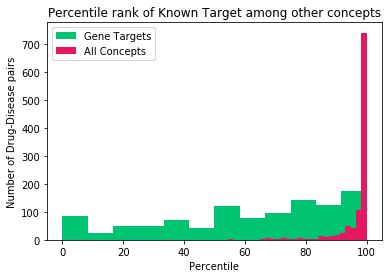

In [242]:
sns.distplot(summary_filt['gene_pct'].dropna(), kde=False, color=c0, hist_kws={'alpha': 1}, label='Gene Targets')
sns.distplot(summary_filt['node_pct'].dropna(), kde=False, color=c1, hist_kws={'alpha': 1}, label='All Concepts')

plt.xlabel('Percentile')
plt.ylabel('Number of Drug-Disease pairs')
plt.legend()
plt.title('Percentile rank of Known Target among other concepts');

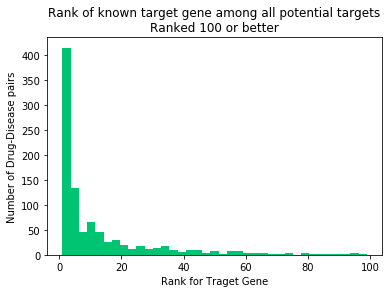

In [237]:
sns.distplot(summary_filt.query('tgt_gene_rank < 100')['tgt_gene_rank'].dropna(), kde=False,  color=c0, hist_kws={'alpha': 1})
plt.xlabel('Rank for Traget Gene')
plt.ylabel('Number of Drug-Disease pairs')
plt.title('Rank of known target gene among all potential targets\nRanked 100 or better');

In [244]:
summary_filt.query('tgt_gene_rank >= 100').shape[0]

116

In [245]:
summary_filt.query('tgt_gene_rank < 100').shape[0]

944

In [300]:
summary_filt.query('tgt_gene_rank <= 10').shape[0]

637

In [246]:
len(summary_filt)

1124

In [247]:
def rr(rank):
    return 1 / rank

In [249]:
summary_filt['gene_rr'] = 1 / summary_filt['tgt_gene_rank']

In [250]:
summary_filt['gene_rr'].mean()

0.3278787742406782

In [252]:
summary_filt['gene_rr']

0       0.020000
1       0.333333
2       0.076923
3       0.500000
4       1.000000
          ...   
1119    0.016667
1120    1.000000
1121    0.083333
1122    0.071429
1123    0.055556
Name: gene_rr, Length: 1124, dtype: float64

In [292]:
summary_filt.drop_duplicates(subset=['comp_id', 'dis_id'])

,comp_id,dis_id,comp_name,dis_name,tgt_id,tgt_name,n_paths,n_tgt_paths,highest_tgt_path,total_nodes,tgt_node_rank,n_tgt_genes,tgt_gene_rank,path_pct,node_pct,gene_pct,dis_depth,gene_rr
0,CHEBI:10033,DOID:6000,warfarin,congestive heart failure,NCBIGene:79001,VKORC1,1742777.0,374.0,219.0,14636.0,124.0,149.0,50.0,99.987434,99.152774,66.442953,4,0.020000
1,CHEBI:10100,DOID:2841,zafirlukast,asthma,NCBIGene:10800,CYSLTR1,207231.0,672.0,24.0,7820.0,5.0,26.0,3.0,99.988419,99.936061,88.461538,5,0.333333
2,CHEBI:101085,DOID:1686,diclofenamide,glaucoma,NCBIGene:759,CA1,5057.0,81.0,37.0,1258.0,26.0,13.0,13.0,99.268341,97.933227,0.000000,5,0.076923
6,CHEBI:10112,DOID:2841,zileuton,asthma,NCBIGene:240,ALOX5,601382.0,959.0,5.0,10567.0,5.0,40.0,2.0,99.999169,99.952683,95.000000,5,0.500000
7,CHEBI:10124,DOID:6364,zolmitriptan,migraine,NCBIGene:3351,HTR1B,14625.0,257.0,2.0,1270.0,3.0,6.0,2.0,99.986325,99.763780,66.666667,5,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,CHEBI:9927,DOID:6000,valsartan,congestive heart failure,NCBIGene:185,AGTR1,2185213.0,2116.0,11.0,12964.0,1.0,114.0,1.0,99.999497,99.992286,99.122807,4,1.000000
1116,CHEBI:9943,DOID:10933,venlafaxine,obsessive-compulsive disorder,NCBIGene:6530,SLC6A2,154382.0,70.0,303.0,4629.0,113.0,183.0,34.0,99.803734,97.558868,81.420765,4,0.029412
1117,CHEBI:9943,DOID:14320,venlafaxine,generalized anxiety disorder,NCBIGene:6530,SLC6A2,1156.0,0.0,NaN,244.0,NaN,28.0,NaN,NaN,NaN,NaN,4,NaN
1118,CHEBI:9943,DOID:2055,venlafaxine,post-traumatic stress disorder,NCBIGene:6530,SLC6A2,9040.0,11.0,371.0,1065.0,155.0,181.0,60.0,95.896018,85.446009,66.850829,4,0.016667


In [293]:
summary_filt.shape[0]

1124

In [294]:
summary_filt.sort_values('gene_rr', ascending=False).drop_duplicates(subset=['comp_id', 'dis_id'])['gene_rr'].mean()

0.5254848862485298